# Week 9 Jupyter Notebook - Gradient Boost
Each week, you will apply the concepts of that week to your Integrated Capstone Project’s dataset. In preparation for Milestone Two, create a Jupyter Notebook (similar to in Module B, Semester Two) that illustrates these lessons. There are no specific questions to answer in your Jupyter Notebook files in this course; your general goal is to analyze your data using the methods you have learned about in this course and in this program and draw interesting conclusions.  

For this week, include ideas such as gradient boost, learning rate, number of estimators, tree depth, and regularization. This homework should be submitted for peer review in the assignment titled 9.3 Peer Review: Week 9 Jupyter Notebook. Complete and submit your Jupyter Notebook homework by 11:59pm ET on Sunday. 

In [1]:
import pandas as pd
def load_collision_data():
    """Load the collision feature datasets"""
    print("\n Loading collision feature datasets...")
    
    injury_df = pd.read_csv('scripts/punt_analytics/injury_collision_features.csv')
    normal_df = pd.read_csv('scripts/punt_analytics/normal_collision_features.csv')
    
    print(f" Loaded {len(injury_df)} injury collisions")
    print(f" Loaded {len(normal_df)} normal collisions")
    
    combined_df = pd.concat([injury_df, normal_df], ignore_index=True)
    print(f" Combined dataset: {len(combined_df)} total collisions")
    print(f" Injury rate: {combined_df['is_injury'].mean():.1%}")
    
    return combined_df, injury_df, normal_df

combined_df, injury_df, normal_df = load_collision_data()


 Loading collision feature datasets...
 Loaded 28 injury collisions
 Loaded 280 normal collisions
 Combined dataset: 308 total collisions
 Injury rate: 9.1%


In [2]:
combined_df.head()

,min_distance,distance_at_start,distance_at_end,avg_distance,time_to_closest_approach,max_relative_speed,avg_relative_speed,relative_speed_at_closest,collision_angle,p1_orientation_at_collision,...,season_year,gamekey,playid,injured_player,partner_player,impact_type,player_activity,partner_activity,friendly_fire,is_injury
0,0.830243,55.032141,14.018631,28.302337,15.8,14.119568,3.188342,11.385286,-91.380383,147.539993,...,2016.0,29.0,538.0,31023.0,31941.0,Helmet-to-body,Tackling,Tackled,No,1
1,0.317649,17.614100,4.200430,12.388854,12.8,7.597745,3.003402,6.844692,-118.178774,265.940002,...,2016.0,144.0,2342.0,32410.0,23259.0,Helmet-to-body,Blocking,Blocked,No,1
2,0.421546,13.157938,3.814251,17.106059,25.3,9.948990,2.790632,0.111793,67.693303,83.870003,...,2016.0,149.0,3663.0,28128.0,29629.0,Helmet-to-body,Blocking,Blocked,No,1
3,0.344385,49.928608,0.344385,36.786561,17.8,15.770312,3.859137,2.517935,-64.178810,94.260002,...,2016.0,189.0,3509.0,27595.0,31950.0,Helmet-to-helmet,Tackled,Tackling,No,1
4,0.541202,4.128255,2.009976,5.784810,19.5,8.200610,1.534932,1.229842,62.487998,64.940002,...,2016.0,231.0,1976.0,32214.0,32807.0,Helmet-to-helmet,Blocked,Blocked,Yes,1


In [3]:
import numpy as np
import pandas as pd

def preprocess_small_dataset(df, target_col='is_injury', remove_outliers=False):
    """preprocessing for small datasets - adapted for gradient boosted regression"""
    print("\n STEP 2: preprocessing for small dataset...")
    
    # Identify feature columns
    exclude_cols = [
        'season_year', 'gamekey', 'playid', 'injured_player', 'partner_player',
        'impact_type', 'player_activity', 'partner_activity', 'friendly_fire', 
        'is_injury'
    ]
    
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    print(f" Identified {len(feature_cols)} potential features")
    
    X = df[feature_cols].copy()
    y = df[target_col].copy()  # Now expecting continuous target variable
    
    # Gradient boosting handles missing data well, but still remove high-missing features
    # Slightly more lenient threshold since GB can use surrogate splits
    missing_pcts = X.isnull().mean()
    high_missing = missing_pcts[missing_pcts > 0.6].index.tolist()  # 60% instead of 50%
    if high_missing:
        print(f"Removing {len(high_missing)} features with >60% missing data")
        X = X.drop(columns=high_missing)
    
    print(f" Features after missing data filter: {X.shape[1]}")
    
    # Simple imputation - gradient boosting works well with median imputation
    print(" Handling missing data with median imputation...")
    for col in X.columns:
        if X[col].isnull().any():
            X[col] = X[col].fillna(X[col].median())
    
    # Create engineered features that work well with gradient boosting
    print(" Creating key engineered features...")
    
    # Collision intensity (gradient boosting can capture non-linear relationships)
    if 'min_distance' in X.columns and 'max_relative_speed' in X.columns:
        X['collision_intensity'] = (1 / (X['min_distance'] + 0.1)) * (X['max_relative_speed'] / X['max_relative_speed'].max())
    
    # Speed ratio
    if 'p1_max_speed' in X.columns and 'p2_max_speed' in X.columns:
        X['speed_ratio'] = X['p1_max_speed'] / (X['p2_max_speed'] + 1e-6)
    
    # More conservative outlier removal since gradient boosting is robust to outliers
    if remove_outliers:
        print(" Conservative outlier removal...")
        outlier_mask = np.zeros(len(X), dtype=bool)
        
        for col in X.select_dtypes(include=[np.number]).columns:
            # More conservative percentiles for tree-based models
            Q1 = X[col].quantile(0.02)  # 2nd percentile instead of 5th
            Q3 = X[col].quantile(0.98)  # 98th percentile instead of 95th
            IQR = Q3 - Q1
            lower_bound = Q1 - 3 * IQR  # Keep 3 IQR threshold
            upper_bound = Q3 + 3 * IQR
            
            col_outliers = (X[col] < lower_bound) | (X[col] > upper_bound)
            outlier_mask |= col_outliers
        
        # Only remove if we don't lose too many samples
        outlier_count = outlier_mask.sum()
        if outlier_count < len(X) * 0.3:  # Don't remove more than 30%
            X = X[~outlier_mask]
            y = y[~outlier_mask]
            print(f"Removed {outlier_count} extreme outliers")
        else:
            print(f"Skipping outlier removal (would remove {outlier_count} samples)")
    
    print(f" Final dataset: {len(X)} samples, {X.shape[1]} features")
    # Changed from class distribution to regression target statistics
    print(f" Target statistics: mean={y.mean():.3f}, std={y.std():.3f}, range=[{y.min():.3f}, {y.max():.3f}]")
    
    return X, y

# Preprocess with conservative settings for gradient boosting
X, y = preprocess_small_dataset(combined_df, remove_outliers=False)  # Skip outlier removal


 STEP 2: preprocessing for small dataset...
 Identified 23 potential features
 Features after missing data filter: 23
 Handling missing data with median imputation...
 Creating key engineered features...
 Final dataset: 308 samples, 25 features
 Target statistics: mean=0.091, std=0.288, range=[0.000, 1.000]


In [6]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import RobustScaler
import pandas as pd

def select_features_small_dataset(X, y, k=8):
    """Feature selection optimized for small datasets with gradient boosted regression"""
    print(f"\n Selecting top {k} features for small dataset...")
    
    # Use fewer features for small datasets to avoid overfitting
    k = min(k, X.shape[1], len(y) // 3)  # Rule: max features = samples/3
    
    if X.shape[1] > k:
        # Changed from f_classif to f_regression for continuous targets
        selector = SelectKBest(score_func=f_regression, k=k)
        X_selected = selector.fit_transform(X, y)
        
        selected_features = X.columns[selector.get_support()].tolist()
        feature_scores = selector.scores_[selector.get_support()]
        
        print(" Selected features (F-statistic scores for regression):")
        for feature, score in zip(selected_features, feature_scores):
            print(f"   {feature:<30} F-Score: {score:.2f}")
        
        X_selected = pd.DataFrame(X_selected, columns=selected_features, index=X.index)
    else:
        X_selected = X
        selected_features = X.columns.tolist()
    
    # Note: Feature scaling is optional for gradient boosting (tree-based models)
    # but can help with regularization and feature importance interpretation
    scaler = RobustScaler()  # RobustScaler works well with tree-based models
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X_selected),
        columns=selected_features,
        index=X_selected.index
    )
    
    return X_scaled, selected_features, scaler

X_scaled, feature_names, scaler = select_features_small_dataset(X, y, k=8)


 Selecting top 8 features for small dataset...
 Selected features (F-statistic scores for regression):
   min_distance                   F-Score: 45.60
   distance_at_end                F-Score: 7.03
   avg_distance                   F-Score: 6.95
   time_to_closest_approach       F-Score: 54.27
   max_relative_speed             F-Score: 87.67
   p2_max_speed                   F-Score: 7.52
   play_duration                  F-Score: 48.04
   collision_intensity            F-Score: 282.39


In [7]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, LeaveOneOut, StratifiedKFold
from sklearn.metrics import classification_report, balanced_accuracy_score, make_scorer
import xgboost as xgb
import pandas as pd

def evaluate_models_small_dataset(X, y, feature_names):
    """Model evaluation with gradient boosting classifiers optimized for small datasets"""
    print("\n Selecting gradient boosting classifier evaluation with cross-validation...")
    
    # Gradient boosting classifiers optimized for small datasets
    models = {
        'GradientBoosting': GradientBoostingClassifier(
            n_estimators=100,        # Moderate number for small datasets
            learning_rate=0.1,       # Standard learning rate
            max_depth=3,             # Shallow trees to prevent overfitting
            min_samples_split=5,     # Conservative split requirement
            min_samples_leaf=2,      # Conservative leaf requirement
            subsample=0.8,           # Stochastic gradient boosting for regularization
            random_state=42
        ),
        'XGBoost_GPU': xgb.XGBClassifier(
            n_estimators=100,        # Moderate number of estimators
            learning_rate=0.1,       # Standard learning rate
            max_depth=4,             # Slightly deeper for XGBoost
            min_child_weight=3,      # Regularization for small datasets
            subsample=0.8,           # Stochastic sampling
            colsample_bytree=0.8,    # Feature sampling for regularization
            reg_alpha=0.1,           # L1 regularization
            reg_lambda=1.0,          # L2 regularization
            device = 'cuda',         # GPU acceleration
            random_state=42
        )
    }
    
    print(f" Dataset: {len(X)} samples, {X.shape[1]} features")
    print(f" Class distribution: {y.value_counts().to_dict()}")
    
    # Use Leave-One-Out CV for very small datasets
    if len(X) < 30:
        cv = LeaveOneOut()
        cv_name = "Leave-One-Out"
    else:
        cv = StratifiedKFold(n_splits=min(5, len(y[y==1])), shuffle=True, random_state=42)
        cv_name = "Stratified K-Fold"
    
    print(f" Using {cv_name} cross-validation...")
    
    results = {}
    
    # Custom scoring for small datasets
    def balanced_accuracy_score_func(y_true, y_pred):
        return balanced_accuracy_score(y_true, y_pred)
    
    for name, model in models.items():
        print(f"\n Evaluating {name}...")
        
        try:
            # Cross-validation scores
            cv_scores_acc = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
            cv_scores_bal = cross_val_score(model, X, y, cv=cv, 
                                          scoring=make_scorer(balanced_accuracy_score_func))
            
            # Fit model on full dataset for analysis
            model.fit(X, y)
            y_pred = model.predict(X)
            y_pred_proba = model.predict_proba(X)[:, 1] if hasattr(model, 'predict_proba') else None
            
            results[name] = {
                'model': model,
                'cv_accuracy': cv_scores_acc,
                'cv_balanced_accuracy': cv_scores_bal,
                'mean_accuracy': cv_scores_acc.mean(),
                'mean_balanced_accuracy': cv_scores_bal.mean(),
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba
            }
            
            print(f"   Accuracy: {cv_scores_acc.mean():.3f} ± {cv_scores_acc.std():.3f}")
            print(f"   Balanced Accuracy: {cv_scores_bal.mean():.3f} ± {cv_scores_bal.std():.3f}")
            
            # Classification report
            report = classification_report(y, y_pred, output_dict=True, zero_division=0)
            if '1' in report:
                print(f"   Injury Detection - Precision: {report['1']['precision']:.3f}, Recall: {report['1']['recall']:.3f}")
            
            # Feature importance for gradient boosting models
            if hasattr(model, 'feature_importances_'):
                importance_df = pd.DataFrame({
                    'feature': feature_names,
                    'importance': model.feature_importances_
                }).sort_values('importance', ascending=False)
                
                print(f"   Top 3 important features:")
                for i, (_, row) in enumerate(importance_df.head(3).iterrows()):
                    print(f"      {i+1}. {row['feature']}: {row['importance']:.3f}")
            
            # Model-specific information
            if name == 'XGBoost_GPU':
                print(f"   GPU training completed successfully")
                
        except Exception as e:
            print(f"    Error evaluating {name}: {str(e)}")
            results[name] = {'error': str(e)}
    
    # Find best model
    valid_results = {k: v for k, v in results.items() if 'error' not in v}
    if valid_results:
        best_model_name = max(valid_results.keys(), key=lambda x: valid_results[x]['mean_balanced_accuracy'])
        best_model = valid_results[best_model_name]['model']
        print(f"\n Best model: {best_model_name}")
    else:
        best_model_name = list(results.keys())[0]
        best_model = None
        print("\n No models evaluated successfully")
    
    return results, best_model, best_model_name

results, best_model, best_model_name = evaluate_models_small_dataset(X_scaled, y, feature_names)


 Selecting gradient boosting classifier evaluation with cross-validation...
 Dataset: 308 samples, 8 features
 Class distribution: {0: 280, 1: 28}
 Using Stratified K-Fold cross-validation...

 Evaluating GradientBoosting...
   Accuracy: 0.961 ± 0.022
   Balanced Accuracy: 0.864 ± 0.088
   Injury Detection - Precision: 1.000, Recall: 1.000
   Top 3 important features:
      1. collision_intensity: 0.742
      2. min_distance: 0.113
      3. max_relative_speed: 0.043

 Evaluating XGBoost_GPU...


/home/pshmo/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:58:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738899731441/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


   Accuracy: 0.958 ± 0.032
   Balanced Accuracy: 0.844 ± 0.115
   Injury Detection - Precision: 0.931, Recall: 0.964
   Top 3 important features:
      1. collision_intensity: 0.659
      2. max_relative_speed: 0.123
      3. min_distance: 0.121
   GPU training completed successfully

 Best model: GradientBoosting



 Selecting analysis for small dataset...
 Feature importance not available
Creating visualizations...


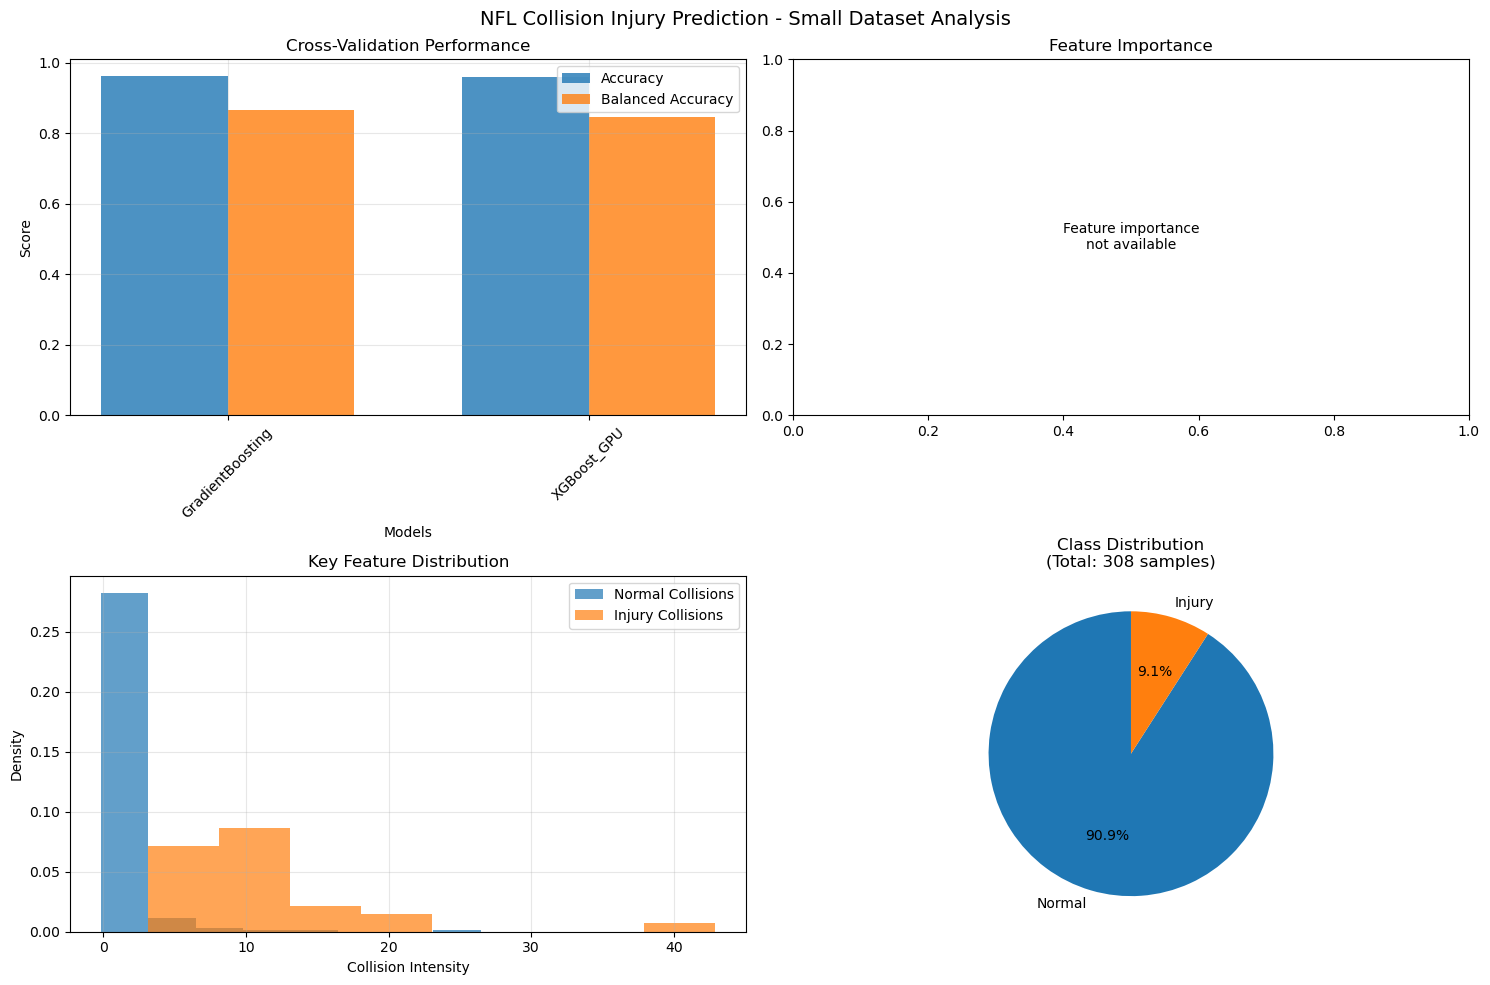

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
def analyze_small_dataset_results(results, X, y, feature_names, best_model, best_model_name):
    """Analysis and visualization for small datasets"""
    print("\n Selecting analysis for small dataset...")
    
    # Feature importance analysis
    if best_model is not None and hasattr(best_model, 'coef_'):
        print(" Analyzing feature importance...")
        importances = np.abs(best_model.coef_[0])
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print(" Top features by importance:")
        for _, row in feature_importance.iterrows():
            print(f"   {row['feature']:<30} {row['importance']:.4f}")
    else:
        feature_importance = None
        print(" Feature importance not available")
    
    # Visualizations for small datasets
    print("Creating visualizations...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('NFL Collision Injury Prediction - Small Dataset Analysis', fontsize=14)
    
    # 1. Cross-validation scores comparison
    ax = axes[0, 0]
    valid_results = {k: v for k, v in results.items() if 'error' not in v}
    
    if valid_results:
        model_names = list(valid_results.keys())
        accuracies = [valid_results[name]['mean_accuracy'] for name in model_names]
        balanced_accuracies = [valid_results[name]['mean_balanced_accuracy'] for name in model_names]
        
        x = np.arange(len(model_names))
        width = 0.35
        
        ax.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8)
        ax.bar(x + width/2, balanced_accuracies, width, label='Balanced Accuracy', alpha=0.8)
        
        ax.set_xlabel('Models')
        ax.set_ylabel('Score')
        ax.set_title('Cross-Validation Performance')
        ax.set_xticks(x)
        ax.set_xticklabels(model_names, rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # 2. Feature importance
    ax = axes[0, 1]
    if feature_importance is not None:
        bars = ax.barh(range(len(feature_importance)), feature_importance['importance'])
        ax.set_yticks(range(len(feature_importance)))
        ax.set_yticklabels(feature_importance['feature'])
        ax.set_xlabel('Importance')
        ax.set_title('Feature Importance')
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'Feature importance\nnot available', 
               ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Feature Importance')
    
    # 3. Data distribution
    ax = axes[1, 0]
    if 'collision_intensity' in X.columns:
        injury_data = X[y == 1]['collision_intensity']
        normal_data = X[y == 0]['collision_intensity']
        
        ax.hist(normal_data, bins=8, alpha=0.7, label='Normal Collisions', density=True)
        ax.hist(injury_data, bins=8, alpha=0.7, label='Injury Collisions', density=True)
        ax.set_xlabel('Collision Intensity')
        ax.set_ylabel('Density')
        ax.set_title('Key Feature Distribution')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # 4. Sample size and class balance
    ax = axes[1, 1]
    class_counts = y.value_counts()
    ax.pie(class_counts.values, labels=['Normal', 'Injury'], autopct='%1.1f%%', startangle=90)
    ax.set_title(f'Class Distribution\n(Total: {len(y)} samples)')
    
    plt.tight_layout()
    plt.show()
    
    return feature_importance

feature_importance = analyze_small_dataset_results(results, X_scaled, y, feature_names, best_model, best_model_name)

In [9]:
def generate_small_dataset_summary(results, best_model_name, X, y, feature_names):
    """Generate summary appropriate for small datasets"""
    print(" SUMMARY - SMALL DATASET COLLISION ANALYSIS")
    
    print(f" Dataset Characteristics:")
    print(f"   - Total samples: {len(y)}")
    print(f"   -  Injury samples: {sum(y)} ({(sum(y)/len(y)):.1%})")
    print(f"   -  Normal samples: {len(y) - sum(y)} ({((len(y) - sum(y))/len(y)):.1%})")
    print(f"   -  Features analyzed: {len(feature_names)}")
    
    valid_results = {k: v for k, v in results.items() if 'error' not in v}
    
    if valid_results and best_model_name in valid_results:
        best_result = valid_results[best_model_name]
        
        print(f"\n Best Model: {best_model_name}")
        print(f"   - Cross-validation Accuracy: {best_result['mean_accuracy']:.3f}")
        print(f"   - Balanced Accuracy: {best_result['mean_balanced_accuracy']:.3f}")
        print(f"   - Features used: {', '.join(feature_names)}")

    return {
        'sample_size': len(y),
        'injury_rate': sum(y)/len(y),
        'best_model': best_model_name,
        'best_accuracy': valid_results[best_model_name]['mean_balanced_accuracy'] if valid_results and best_model_name in valid_results else None
    }

summary = generate_small_dataset_summary(results, best_model_name, X_scaled, y, feature_names)

# Store results
small_dataset_results = {
    'X': X_scaled,
    'y': y,
    'results': results,
    'best_model': best_model,
    'feature_names': feature_names,
    'feature_importance': feature_importance,
    'summary': summary
}

 SUMMARY - SMALL DATASET COLLISION ANALYSIS
 Dataset Characteristics:
   - Total samples: 308
   -  Injury samples: 28 (9.1%)
   -  Normal samples: 280 (90.9%)
   -  Features analyzed: 8

 Best Model: GradientBoosting
   - Cross-validation Accuracy: 0.961
   - Balanced Accuracy: 0.864
   - Features used: min_distance, distance_at_end, avg_distance, time_to_closest_approach, max_relative_speed, p2_max_speed, play_duration, collision_intensity



 GRADIENT BOOSTING HYPERPARAMETER EXPLORATION...
 Testing 6 parameter types with dataset: 308 samples, 8 features

 Evaluating Learning Rate (Shrinkage)...
   learning_rate=0.01: 0.831 ± 0.081
   learning_rate=0.05: 0.881 ± 0.067
   learning_rate=0.1: 0.864 ± 0.088
   learning_rate=0.15: 0.881 ± 0.067
   learning_rate=0.2: 0.901 ± 0.082
   learning_rate=0.3: 0.901 ± 0.082

 Evaluating Number of Boosting Stages...
   n_estimators=25: 0.879 ± 0.068
   n_estimators=50: 0.881 ± 0.067
   n_estimators=75: 0.864 ± 0.088
   n_estimators=100: 0.864 ± 0.088
   n_estimators=150: 0.901 ± 0.082
   n_estimators=200: 0.881 ± 0.067
   n_estimators=300: 0.901 ± 0.082

 Evaluating Maximum Tree Depth...
   max_depth=2: 0.903 ± 0.081
   max_depth=3: 0.864 ± 0.088
   max_depth=4: 0.881 ± 0.067
   max_depth=5: 0.881 ± 0.067
   max_depth=6: 0.881 ± 0.067
   max_depth=8: 0.881 ± 0.067

 Evaluating Subsample Ratio (Stochastic GB)...
   subsample=0.6: 0.881 ± 0.067
   subsample=0.7: 0.901 ± 0.082
   subsample=

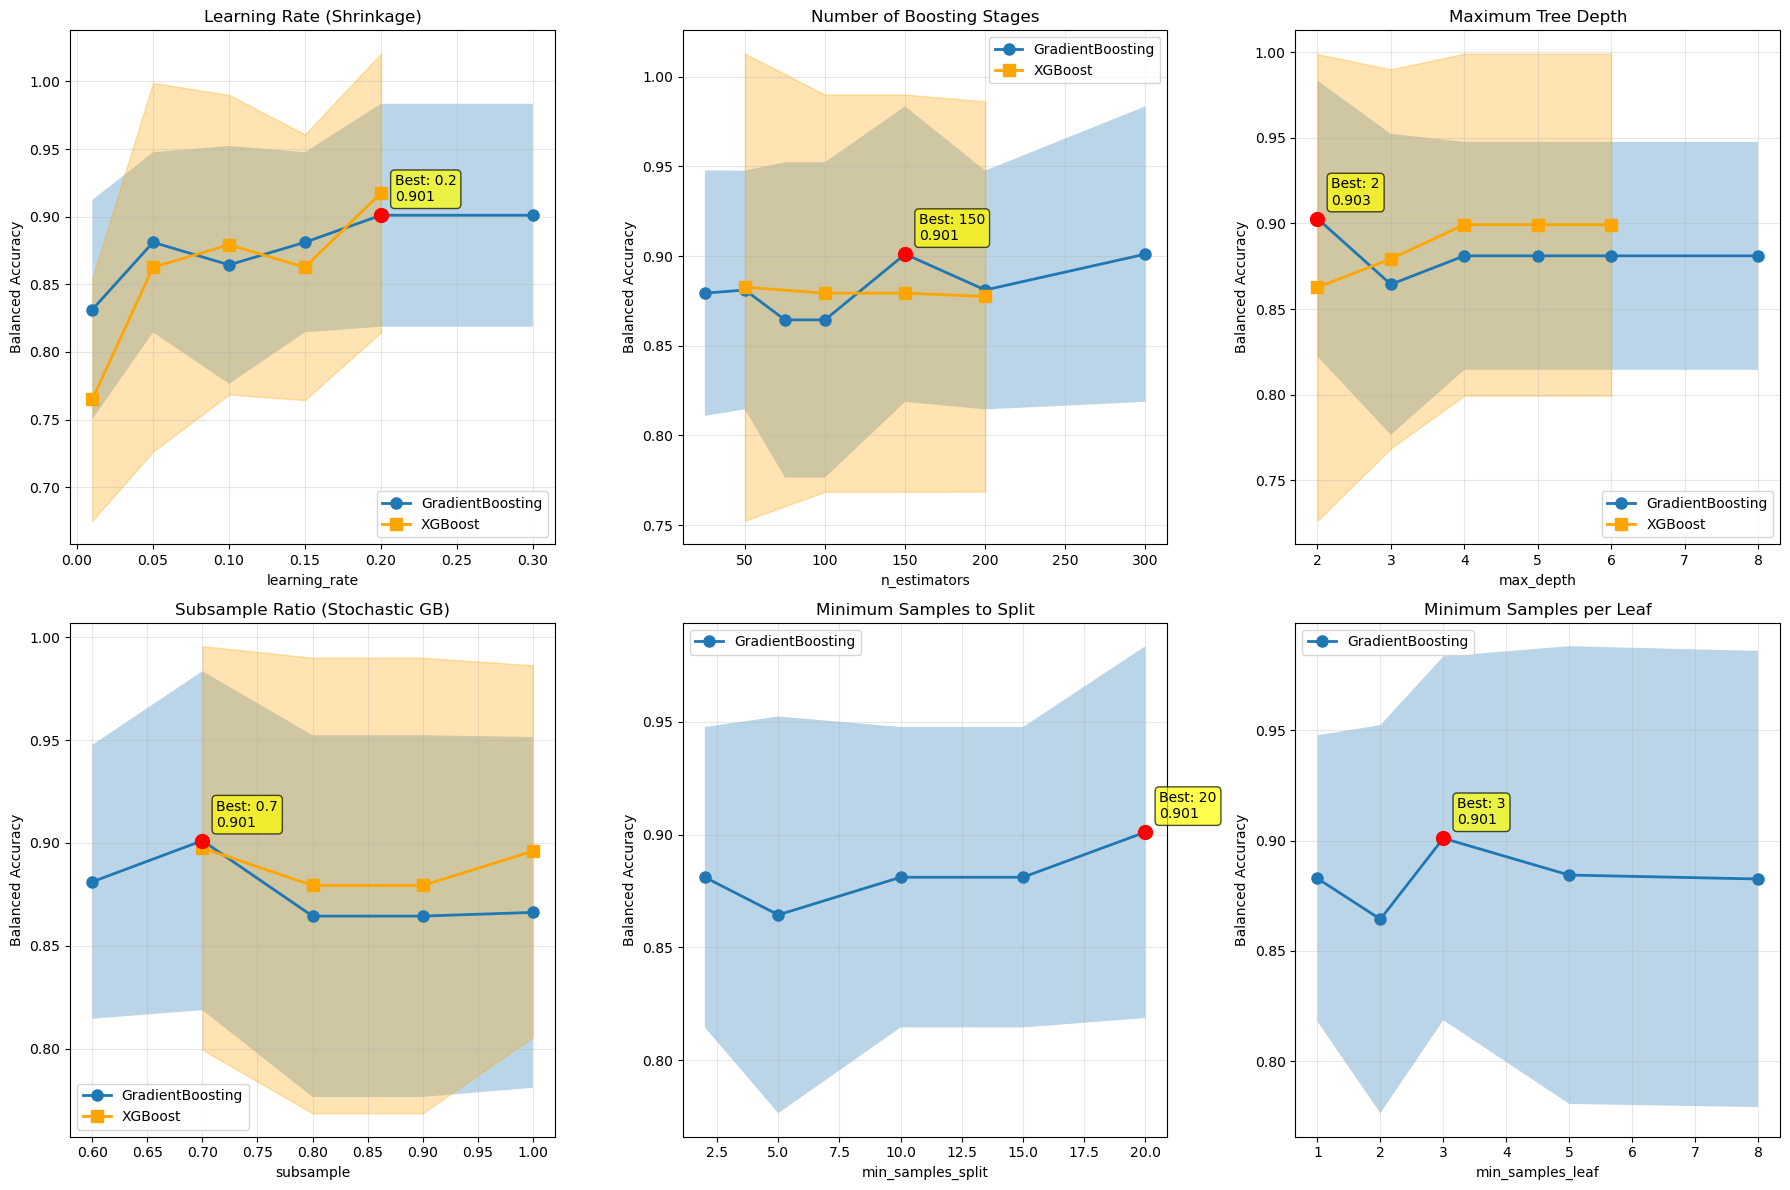


 Creating parameter interaction heatmap...


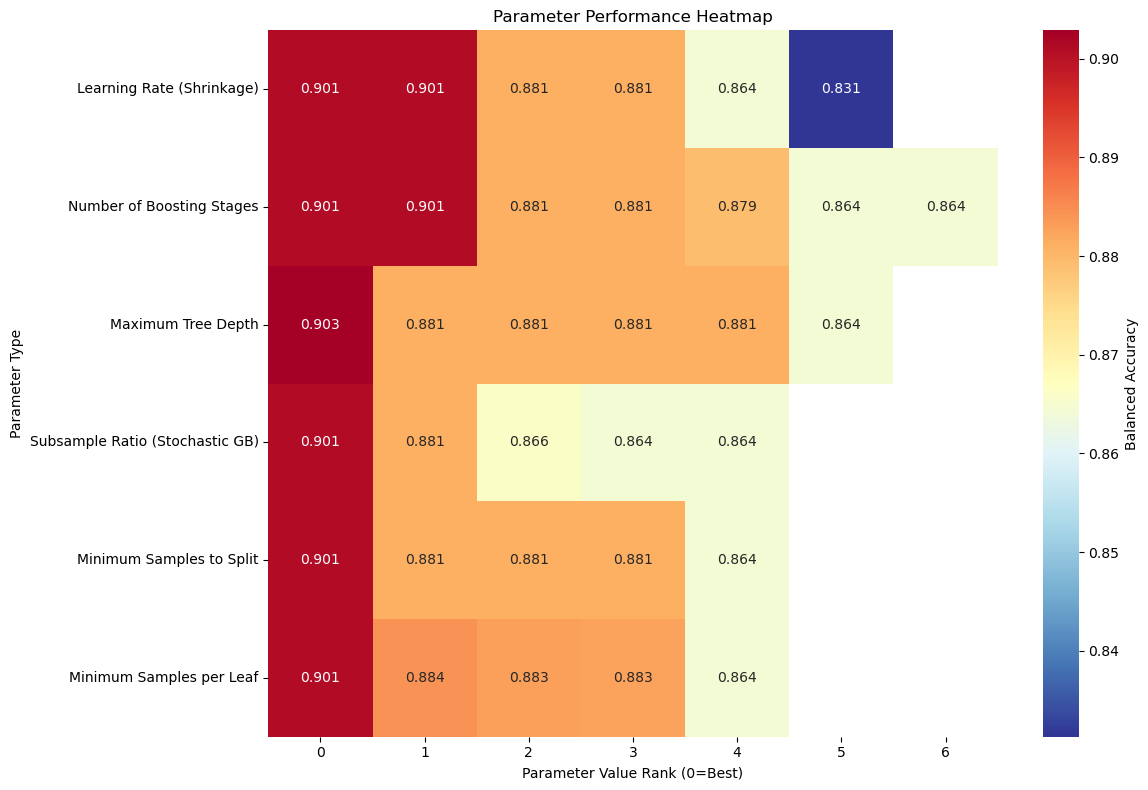


 COMPREHENSIVE GRID SEARCH OPTIMIZATION...
 Grid search with refined parameters:
   learning_rate: [0.2, 0.3, 0.05]
   n_estimators: [150, 300, 50]
   max_depth: [2, 4, 5]
   subsample: [0.7, 0.6, 1.0]
   min_samples_split: [20, 2, 10]
   min_samples_leaf: [3, 5, 1]
Fitting 5 folds for each of 729 candidates, totalling 3645 fits

 Grid Search Results:
   Best Parameters: {'learning_rate': 0.2, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150, 'subsample': 1.0}
   Best Score: 0.958


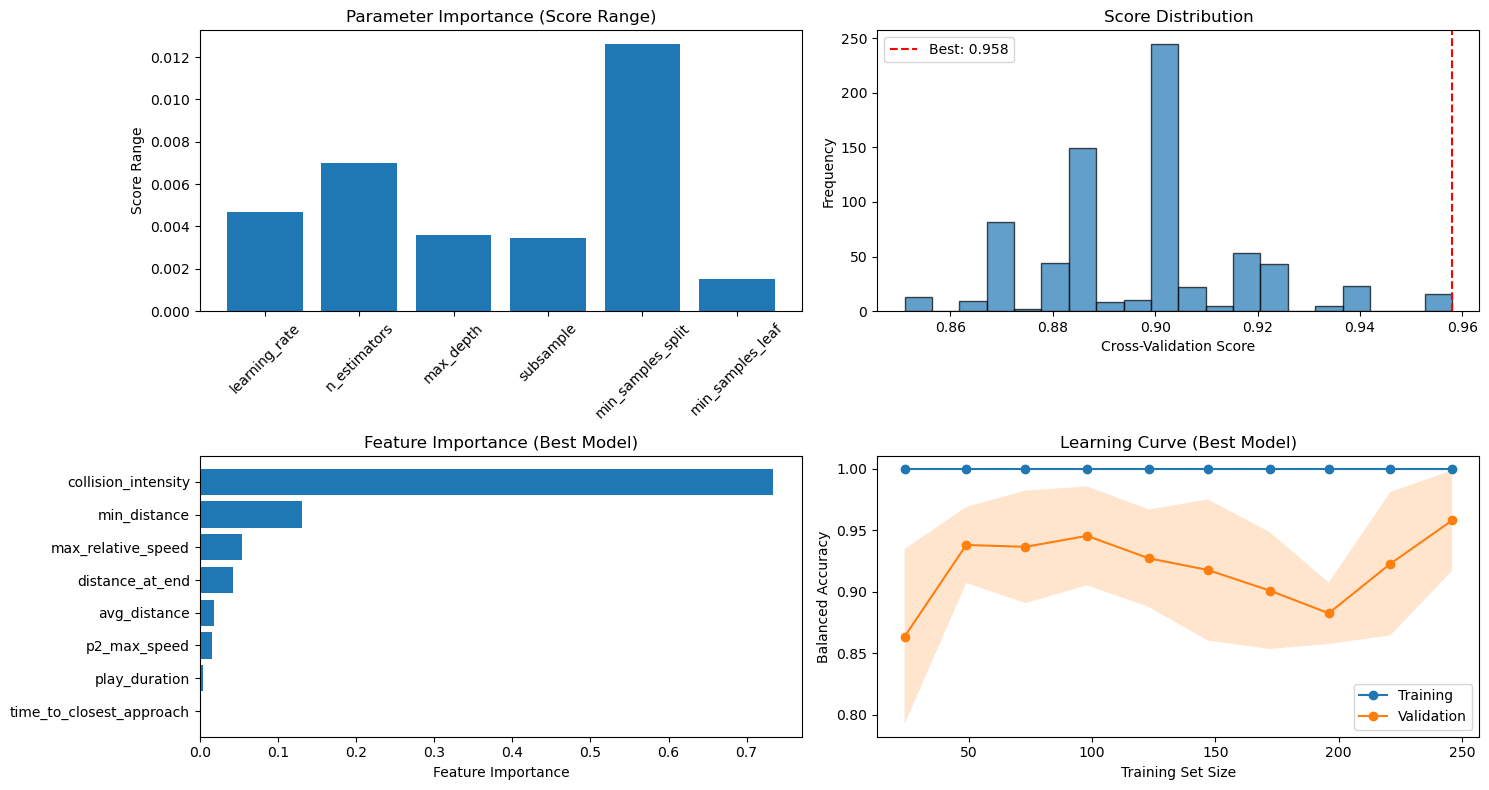

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import (StratifiedKFold, cross_val_score, learning_curve, 
                                   validation_curve, GridSearchCV)
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, 
                           roc_auc_score, balanced_accuracy_score, make_scorer)
import xgboost as xgb

def evaluate_gb_hyperparameters(X, y, feature_names):
    """gradient boosting hyperparameter exploration"""
    print("\n GRADIENT BOOSTING HYPERPARAMETER EXPLORATION...")
    
    # Parameter grids for exploration
    parameter_sets = {
        'learning_rate': {
            'param_name': 'learning_rate',
            'param_values': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
            'description': 'Learning Rate (Shrinkage)'
        },
        'n_estimators': {
            'param_name': 'n_estimators', 
            'param_values': [25, 50, 75, 100, 150, 200, 300],
            'description': 'Number of Boosting Stages'
        },
        'max_depth': {
            'param_name': 'max_depth',
            'param_values': [2, 3, 4, 5, 6, 8],
            'description': 'Maximum Tree Depth'
        },
        'subsample': {
            'param_name': 'subsample',
            'param_values': [0.6, 0.7, 0.8, 0.9, 1.0],
            'description': 'Subsample Ratio (Stochastic GB)'
        },
        'min_samples_split': {
            'param_name': 'min_samples_split',
            'param_values': [2, 5, 10, 15, 20],
            'description': 'Minimum Samples to Split'
        },
        'min_samples_leaf': {
            'param_name': 'min_samples_leaf',
            'param_values': [1, 2, 3, 5, 8],
            'description': 'Minimum Samples per Leaf'
        }
    }
    
    results = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    print(f" Testing {len(parameter_sets)} parameter types with dataset: {len(X)} samples, {X.shape[1]} features")
    
    for param_set_name, param_config in parameter_sets.items():
        print(f"\n Evaluating {param_config['description']}...")
        
        param_results = {}
        
        for param_value in param_config['param_values']:
            # Base model configuration
            base_params = {
                'n_estimators': 100,
                'learning_rate': 0.1,
                'max_depth': 3,
                'min_samples_split': 5,
                'min_samples_leaf': 2,
                'subsample': 0.8,
                'random_state': 42
            }
            
            # Update with current parameter being tested
            base_params[param_config['param_name']] = param_value
            
            model = GradientBoostingClassifier(**base_params)
            
            # Cross-validation scores
            cv_scores = cross_val_score(model, X, y, cv=cv, scoring='balanced_accuracy')
            
            param_results[param_value] = {
                'mean_score': cv_scores.mean(),
                'std_score': cv_scores.std(),
                'model': model
            }
            
            print(f"   {param_config['param_name']}={param_value}: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
        
        results[param_set_name] = {
            'config': param_config,
            'results': param_results
        }
    
    return results

def evaluate_xgboost_hyperparameters(X, y):
    """XGBoost specific hyperparameter exploration"""
    print("\n XGBOOST HYPERPARAMETER EXPLORATION...")
    
    xgb_parameter_sets = {
        'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
        'max_depth': [2, 3, 4, 5, 6],
        'n_estimators': [50, 100, 150, 200],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
        'reg_alpha': [0, 0.01, 0.1, 0.5],  # L1 regularization
        'reg_lambda': [0.1, 0.5, 1.0, 2.0]  # L2 regularization
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = {}
    
    for param_name, param_values in xgb_parameter_sets.items():
        print(f"\n Evaluating XGBoost {param_name}...")
        
        param_results = {}
        
        for param_value in param_values:
            base_params = {
                'n_estimators': 100,
                'learning_rate': 0.1,
                'max_depth': 3,
                'subsample': 0.8,
                'colsample_bytree': 0.8,
                'reg_alpha': 0.1,
                'reg_lambda': 1.0,
                'device': 'cuda:0',
                'random_state': 42
            }
            
            base_params[param_name] = param_value
            
            try:
                model = xgb.XGBClassifier(**base_params)
                cv_scores = cross_val_score(model, X, y, cv=cv, scoring='balanced_accuracy')
                
                param_results[param_value] = {
                    'mean_score': cv_scores.mean(),
                    'std_score': cv_scores.std(),
                    'model': model
                }
                
                print(f"   {param_name}={param_value}: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
                
            except Exception as e:
                print(f"   {param_name}={param_value}: Error - {str(e)}")
                param_results[param_value] = {'error': str(e)}
        
        results[param_name] = param_results
    
    return results

def plot_parameter_exploration(gb_results, xgb_results=None):
    """Create comprehensive visualization of parameter exploration"""
    print("\n Creating parameter exploration visualizations...")
    
    n_params = len(gb_results)
    n_cols = 3
    n_rows = (n_params + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    plot_idx = 0
    
    for param_name, param_data in gb_results.items():
        row = plot_idx // n_cols
        col = plot_idx % n_cols
        ax = axes[row, col]
        
        # Extract data for plotting
        param_values = list(param_data['results'].keys())
        means = [param_data['results'][val]['mean_score'] for val in param_values]
        stds = [param_data['results'][val]['std_score'] for val in param_values]
        
        # Plot line with error bars
        ax.plot(param_values, means, 'o-', linewidth=2, markersize=8, label='GradientBoosting')
        ax.fill_between(param_values, 
                       [m - s for m, s in zip(means, stds)],
                       [m + s for m, s in zip(means, stds)],
                       alpha=0.3)
        
        # Add XGBoost comparison if available
        if xgb_results and param_name in ['learning_rate', 'max_depth', 'n_estimators', 'subsample']:
            xgb_param_name = param_name
            if xgb_param_name in xgb_results:
                xgb_means = []
                xgb_stds = []
                xgb_values = []
                
                for val in param_values:
                    if val in xgb_results[xgb_param_name] and 'mean_score' in xgb_results[xgb_param_name][val]:
                        xgb_values.append(val)
                        xgb_means.append(xgb_results[xgb_param_name][val]['mean_score'])
                        xgb_stds.append(xgb_results[xgb_param_name][val]['std_score'])
                
                if xgb_means:
                    ax.plot(xgb_values, xgb_means, 's-', linewidth=2, markersize=8, 
                           label='XGBoost', color='orange')
                    ax.fill_between(xgb_values,
                                   [m - s for m, s in zip(xgb_means, xgb_stds)],
                                   [m + s for m, s in zip(xgb_means, xgb_stds)],
                                   alpha=0.3, color='orange')
        
        ax.set_xlabel(param_data['config']['param_name'])
        ax.set_ylabel('Balanced Accuracy')
        ax.set_title(param_data['config']['description'])
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        # Highlight best value
        best_idx = np.argmax(means)
        best_val = param_values[best_idx]
        best_score = means[best_idx]
        ax.scatter([best_val], [best_score], color='red', s=100, zorder=5)
        ax.annotate(f'Best: {best_val}\n{best_score:.3f}', 
                   xy=(best_val, best_score), xytext=(10, 10),
                   textcoords='offset points', ha='left',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
        
        plot_idx += 1
    
    # Hide unused subplots
    for i in range(plot_idx, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def create_heatmap_analysis(gb_results):
    """Create heatmap showing parameter interactions"""
    print("\n Creating parameter interaction heatmap...")
    
    # Extract best parameters for each parameter type
    best_params = {}
    param_scores = {}
    
    for param_name, param_data in gb_results.items():
        scores = [(val, data['mean_score']) for val, data in param_data['results'].items()]
        scores.sort(key=lambda x: x[1], reverse=True)
        
        best_params[param_name] = scores[0][0]
        param_scores[param_name] = [score[1] for score in scores]
    
    # Create heatmap data
    param_names = list(gb_results.keys())
    heatmap_data = []
    
    for param_name in param_names:
        row_data = []
        for score in param_scores[param_name]:
            row_data.append(score)
        heatmap_data.append(row_data)
    
    # Find max length for padding
    max_len = max(len(row) for row in heatmap_data)
    for i, row in enumerate(heatmap_data):
        while len(row) < max_len:
            row.append(np.nan)
    
    heatmap_data = np.array(heatmap_data)
    
    plt.figure(figsize=(12, 8))
    mask = np.isnan(heatmap_data)
    sns.heatmap(heatmap_data, 
                yticklabels=[gb_results[name]['config']['description'] for name in param_names],
                cmap='RdYlBu_r',
                mask=mask,
                annot=True, 
                fmt='.3f',
                cbar_kws={'label': 'Balanced Accuracy'})
    
    plt.title('Parameter Performance Heatmap')
    plt.xlabel('Parameter Value Rank (0=Best)')
    plt.ylabel('Parameter Type')
    plt.tight_layout()
    plt.show()
    
    return best_params

def perform_comprehensive_grid_search(X, y, gb_results):
    """Perform grid search using insights from parameter exploration"""
    print("\n COMPREHENSIVE GRID SEARCH OPTIMIZATION...")
    
    # Extract top-performing parameter ranges
    refined_params = {}
    
    for param_name, param_data in gb_results.items():
        # Get top 3 performing values for each parameter
        scores = [(val, data['mean_score']) for val, data in param_data['results'].items()]
        scores.sort(key=lambda x: x[1], reverse=True)
        top_values = [score[0] for score in scores[:3]]
        
        param_key = param_data['config']['param_name']
        refined_params[param_key] = top_values
    
    print(f" Grid search with refined parameters:")
    for param, values in refined_params.items():
        print(f"   {param}: {values}")
    
    # Perform grid search
    gb_model = GradientBoostingClassifier(random_state=42)
    grid_search = GridSearchCV(
        gb_model,
        refined_params,
        cv=5,
        scoring='balanced_accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X, y)
    
    print(f"\n Grid Search Results:")
    print(f"   Best Parameters: {grid_search.best_params_}")
    print(f"   Best Score: {grid_search.best_score_:.3f}")
    
    # Analyze parameter importance
    results_df = pd.DataFrame(grid_search.cv_results_)
    
    plt.figure(figsize=(15, 8))
    
    # Plot parameter importance
    param_importance = {}
    for param in refined_params.keys():
        param_col = f'param_{param}'
        if param_col in results_df.columns:
            grouped = results_df.groupby(param_col)['mean_test_score'].agg(['mean', 'std'])
            param_importance[param] = grouped['mean'].max() - grouped['mean'].min()
    
    plt.subplot(2, 2, 1)
    params = list(param_importance.keys())
    importance = list(param_importance.values())
    plt.bar(params, importance)
    plt.title('Parameter Importance (Score Range)')
    plt.xticks(rotation=45)
    plt.ylabel('Score Range')
    
    # Plot score distribution
    plt.subplot(2, 2, 2)
    plt.hist(results_df['mean_test_score'], bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(grid_search.best_score_, color='red', linestyle='--', 
                label=f'Best: {grid_search.best_score_:.3f}')
    plt.xlabel('Cross-Validation Score')
    plt.ylabel('Frequency')
    plt.title('Score Distribution')
    plt.legend()
    
    # Feature importance from best model
    plt.subplot(2, 2, 3)
    best_model = grid_search.best_estimator_
    if hasattr(best_model, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=True)
        
        plt.barh(importance_df['feature'], importance_df['importance'])
        plt.xlabel('Feature Importance')
        plt.title('Feature Importance (Best Model)')
    
    # Learning curve for best model
    plt.subplot(2, 2, 4)
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes_abs, train_scores, val_scores = learning_curve(
        best_model, X, y, train_sizes=train_sizes, cv=5, scoring='balanced_accuracy'
    )
    
    plt.plot(train_sizes_abs, np.mean(train_scores, axis=1), 'o-', label='Training')
    plt.plot(train_sizes_abs, np.mean(val_scores, axis=1), 'o-', label='Validation')
    plt.fill_between(train_sizes_abs,
                     np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                     np.mean(train_scores, axis=1) + np.std(train_scores, axis=1),
                     alpha=0.2)
    plt.fill_between(train_sizes_abs,
                     np.mean(val_scores, axis=1) - np.std(val_scores, axis=1),
                     np.mean(val_scores, axis=1) + np.std(val_scores, axis=1),
                     alpha=0.2)
    plt.xlabel('Training Set Size')
    plt.ylabel('Balanced Accuracy')
    plt.title('Learning Curve (Best Model)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return grid_search

# Run the comprehensive parameter exploration
gb_results = evaluate_gb_hyperparameters(X_scaled, y, feature_names)
xgb_results = evaluate_xgboost_hyperparameters(X_scaled, y)

# Create visualizations
plot_parameter_exploration(gb_results, xgb_results)
best_params = create_heatmap_analysis(gb_results)
final_grid_search = perform_comprehensive_grid_search(X_scaled, y, gb_results)

## Dataset 2

In [15]:
def load_play_surface_data():
    """Load the collision feature datasets"""
    print("\n Loading collision feature datasets...")
    
    play_surface_df = pd.read_csv('datasets/nfl-playing-surface-analytics/processed_motion_features.csv')
    
    print(f" Loaded {len(play_surface_df)} plays")
    
    return play_surface_df

play_surface_df = load_play_surface_data()


 Loading collision feature datasets...
 Loaded 266960 plays


In [16]:
def preprocess_dataset(df, target_col='injury', remove_outliers=False):
    """Preprocessing for injury prediction dataset"""
    print("\n Preprocessing for the play surface dataset...")
    
    # Identify feature columns to exclude
    exclude_cols = [
        # Target variable
        'injury',
        # Days to match variables (future leakage)
        'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42', 
        # Body part information (outcome-related, not predictive features)
        'BodyPart_Foot', 'BodyPart_Heel', 'BodyPart_Knee',
        'BodyPart_Non-Injury', 'BodyPart_Toes',
        # Identifier columns
        'PlayKey', 'PlayerDay', 'PlayerGame'
    ]
    
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    print(f" Identified {len(feature_cols)} potential features")
    
    X = df[feature_cols].copy()
    y = df[target_col].copy()
    
    # Remove features with >50% missing data
    missing_pcts = X.isnull().mean()
    high_missing = missing_pcts[missing_pcts > 0.5].index.tolist()
    if high_missing:
        print(f" Removing {len(high_missing)} features with >50% missing data: {high_missing}")
        X = X.drop(columns=high_missing)
    
    print(f" Features after missing data filter: {X.shape[1]}")
    
    # Handle missing data with appropriate imputation
    print(" Handling missing data...")
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    categorical_cols = X.select_dtypes(include=['object', 'bool']).columns
    
    # Median imputation for numeric features
    for col in numeric_cols:
        if X[col].isnull().any():
            X[col] = X[col].fillna(X[col].median())
    
    # Mode imputation for categorical features
    for col in categorical_cols:
        if X[col].isnull().any():
            X[col] = X[col].fillna(X[col].mode()[0] if not X[col].mode().empty else 0)
    
    # Create engineered features specific to this dataset
    print(" Creating engineered features...")
    
    # Movement intensity score
    if 'max_speed' in X.columns and 'max_acceleration' in X.columns:
        X['movement_intensity'] = (X['max_speed'] / X['max_speed'].max()) * (X['max_acceleration'] / X['max_acceleration'].max())
    
    # Workload indicators
    if 'total_distance' in X.columns and 'play_duration' in X.columns:
        X['distance_per_second'] = X['total_distance'] / (X['play_duration'] + 1e-6)
    
    # Risk indicators based on rapid movements
    if 'rapid_accelerations' in X.columns and 'rapid_decelerations' in X.columns:
        X['total_rapid_movements'] = X['rapid_accelerations'] + X['rapid_decelerations']
    
    # Direction change intensity
    if 'total_direction_change' in X.columns and 'play_duration' in X.columns:
        X['direction_change_rate'] = X['total_direction_change'] / (X['play_duration'] + 1e-6)
    
    # Jerk-based instability indicator
    if 'max_jerk' in X.columns and 'avg_jerk' in X.columns:
        X['jerk_variability'] = X['max_jerk'] / (X['avg_jerk'] + 1e-6)
    
    # Speed consistency
    if 'max_speed' in X.columns and 'avg_speed' in X.columns:
        X['speed_consistency'] = X['avg_speed'] / (X['max_speed'] + 1e-6)
    
    # Fatigue/efficiency indicators
    if 'movement_efficiency' in X.columns and 'time_above_avg_speed' in X.columns:
        X['performance_ratio'] = X['movement_efficiency'] * X['time_above_avg_speed']
    
    # Conservative outlier removal for numeric features only
    if remove_outliers:
        print(" Conservative outlier removal...")
        outlier_mask = np.zeros(len(X), dtype=bool)
        
        for col in X.select_dtypes(include=[np.number]).columns:
            if X[col].std() > 0:  # Only process columns with variation
                Q1 = X[col].quantile(0.05)  # More conservative percentiles
                Q3 = X[col].quantile(0.95)
                IQR = Q3 - Q1
                lower_bound = Q1 - 3 * IQR  # 3 IQR instead of 1.5
                upper_bound = Q3 + 3 * IQR
                
                col_outliers = (X[col] < lower_bound) | (X[col] > upper_bound)
                outlier_mask |= col_outliers
        
        # Only remove if we don't lose too many samples
        outlier_count = outlier_mask.sum()
        if outlier_count < len(X) * 0.3:  # Don't remove more than 30%
            X = X[~outlier_mask]
            y = y[~outlier_mask]
            print(f" Removed {outlier_count} extreme outliers")
        else:
            print(f" Skipping outlier removal (would remove {outlier_count} samples)")
    
    # Ensure all features are numeric for modeling
    print(" Final data type conversion...")
    
    # Convert boolean columns to numeric
    bool_cols = X.select_dtypes(include=['bool']).columns
    for col in bool_cols:
        X[col] = X[col].astype(int)
    
    # Handle any remaining categorical columns
    remaining_categorical = X.select_dtypes(include=['object']).columns
    if len(remaining_categorical) > 0:
        print(f" Converting categorical columns to numeric: {list(remaining_categorical)}")
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        for col in remaining_categorical:
            X[col] = le.fit_transform(X[col].astype(str))
    
    print(f" Final dataset: {len(X)} samples, {X.shape[1]} features")
    print(f" Class distribution: {y.value_counts().to_dict()}")
    print(f" Injury rate: {y.mean():.1%}")
    
    # Display feature categories for reference
    movement_features = [col for col in X.columns if any(keyword in col.lower() 
                        for keyword in ['speed', 'acceleration', 'distance', 'jerk'])]
    positional_features = [col for col in X.columns if 'RosterPosition_' in col]
    play_features = [col for col in X.columns if 'PlayType_' in col]
    field_features = [col for col in X.columns if 'FieldType_' in col]
    engineered_features = [col for col in X.columns if any(keyword in col.lower() 
                          for keyword in ['intensity', 'ratio', 'rate', 'consistency', 'variability'])]
    
    print(f"\n Feature categories:")
    print(f"   Movement features: {len(movement_features)}")
    print(f"   Position features: {len(positional_features)}")
    print(f"   Play type features: {len(play_features)}")
    print(f"   Field features: {len(field_features)}")
    print(f"   Engineered features: {len(engineered_features)}")
    
    return X, y

# Usage example:
X, y = preprocess_dataset(play_surface_df, target_col='injury', remove_outliers=False)


 Preprocessing for the play surface dataset...
 Identified 53 potential features
 Features after missing data filter: 53
 Handling missing data...
 Creating engineered features...
 Final data type conversion...
 Final dataset: 266960 samples, 60 features
 Class distribution: {0.0: 266856, 1.0: 104}
 Injury rate: 0.0%

 Feature categories:
   Movement features: 21
   Position features: 9
   Play type features: 11
   Field features: 1
   Engineered features: 13


In [17]:
X_scaled, feature_names, scaler = select_features_small_dataset(X, y, k=10)


 Selecting top 10 features for small dataset...
 Selected features (F-statistic scores for regression):
   distance_std                   F-Score: 38.64
   max_speed                      F-Score: 28.77
   speed_std                      F-Score: 35.84
   x_range                        F-Score: 34.00
   speed_95th                     F-Score: 26.75
   displacement                   F-Score: 55.83
   movement_efficiency            F-Score: 45.46
   PlayType_Kickoff               F-Score: 20.86
   PlayType_Punt                  F-Score: 20.90
   performance_ratio              F-Score: 17.56



 COMPREHENSIVE XGBOOST GPU ANALYSIS WITH PROPER VALIDATION
 Splitting original data into train/test...
Original train set: 213568 samples
  Class distribution: {0.0: 213485, 1.0: 83}
Original test set: 53392 samples
  Class distribution: {0.0: 53371, 1.0: 21}

 Creating resampled training data...

 ENHANCED RESAMPLING PIPELINE FOR GRADIENT BOOSTING
Original class distribution: {0.0: 213485, 1.0: 83}
Imbalance ratio: 0.0004
Minority class size: 83

Resampling parameters:
  Undersample ratio: 0.020
  Oversample ratio: 0.150
  SMOTE k_neighbors: 5

Applying resampling...
Resampled distribution: {0.0: 4150, 1.0: 622}
New imbalance ratio: 0.1499
Data size change: 213568 → 4772 samples

 CROSS-VALIDATION ON TRAINING DATA

 Cross-validation on ORIGINAL training data:

 Evaluating XGBoost_GPU...


/home/pshmo/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pshmo/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pshmo/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

  Balanced Accuracy: 0.500 ± 0.000
  F1 Score: 0.000 ± 0.000
  Recall: 0.000 ± 0.000
  Precision: 0.000 ± 0.000
  ROC AUC: 0.675 ± 0.059

 Cross-validation on RESAMPLED training data:

 Evaluating XGBoost_GPU...
  Balanced Accuracy: 0.698 ± 0.032
  F1 Score: 0.550 ± 0.066
  Recall: 0.405 ± 0.065
  Precision: 0.871 ± 0.026
  ROC AUC: 0.880 ± 0.039

 FINAL EVALUATION ON ORIGINAL HOLDOUT TEST SET

 Testing Original_XGBoost_GPU on original holdout test set...
  Top 3 features: movement_efficiency, speed_95th, displacement
  Balanced Accuracy: 0.500
  ROC AUC: 0.588
  Precision: 0.000
  Recall: 0.000
  F1 Score: 0.000

 Testing Resampled_XGBoost_GPU on original holdout test set...
  Top 3 features: movement_efficiency, displacement, distance_std
  Balanced Accuracy: 0.494
  ROC AUC: 0.458
  Precision: 0.000
  Recall: 0.000
  F1 Score: 0.000

 COMPREHENSIVE ANALYSIS

 PERFORMANCE COMPARISON ON ORIGINAL HOLDOUT TEST SET:
                       Balanced Accuracy  ROC AUC  Precision  Recall  F1

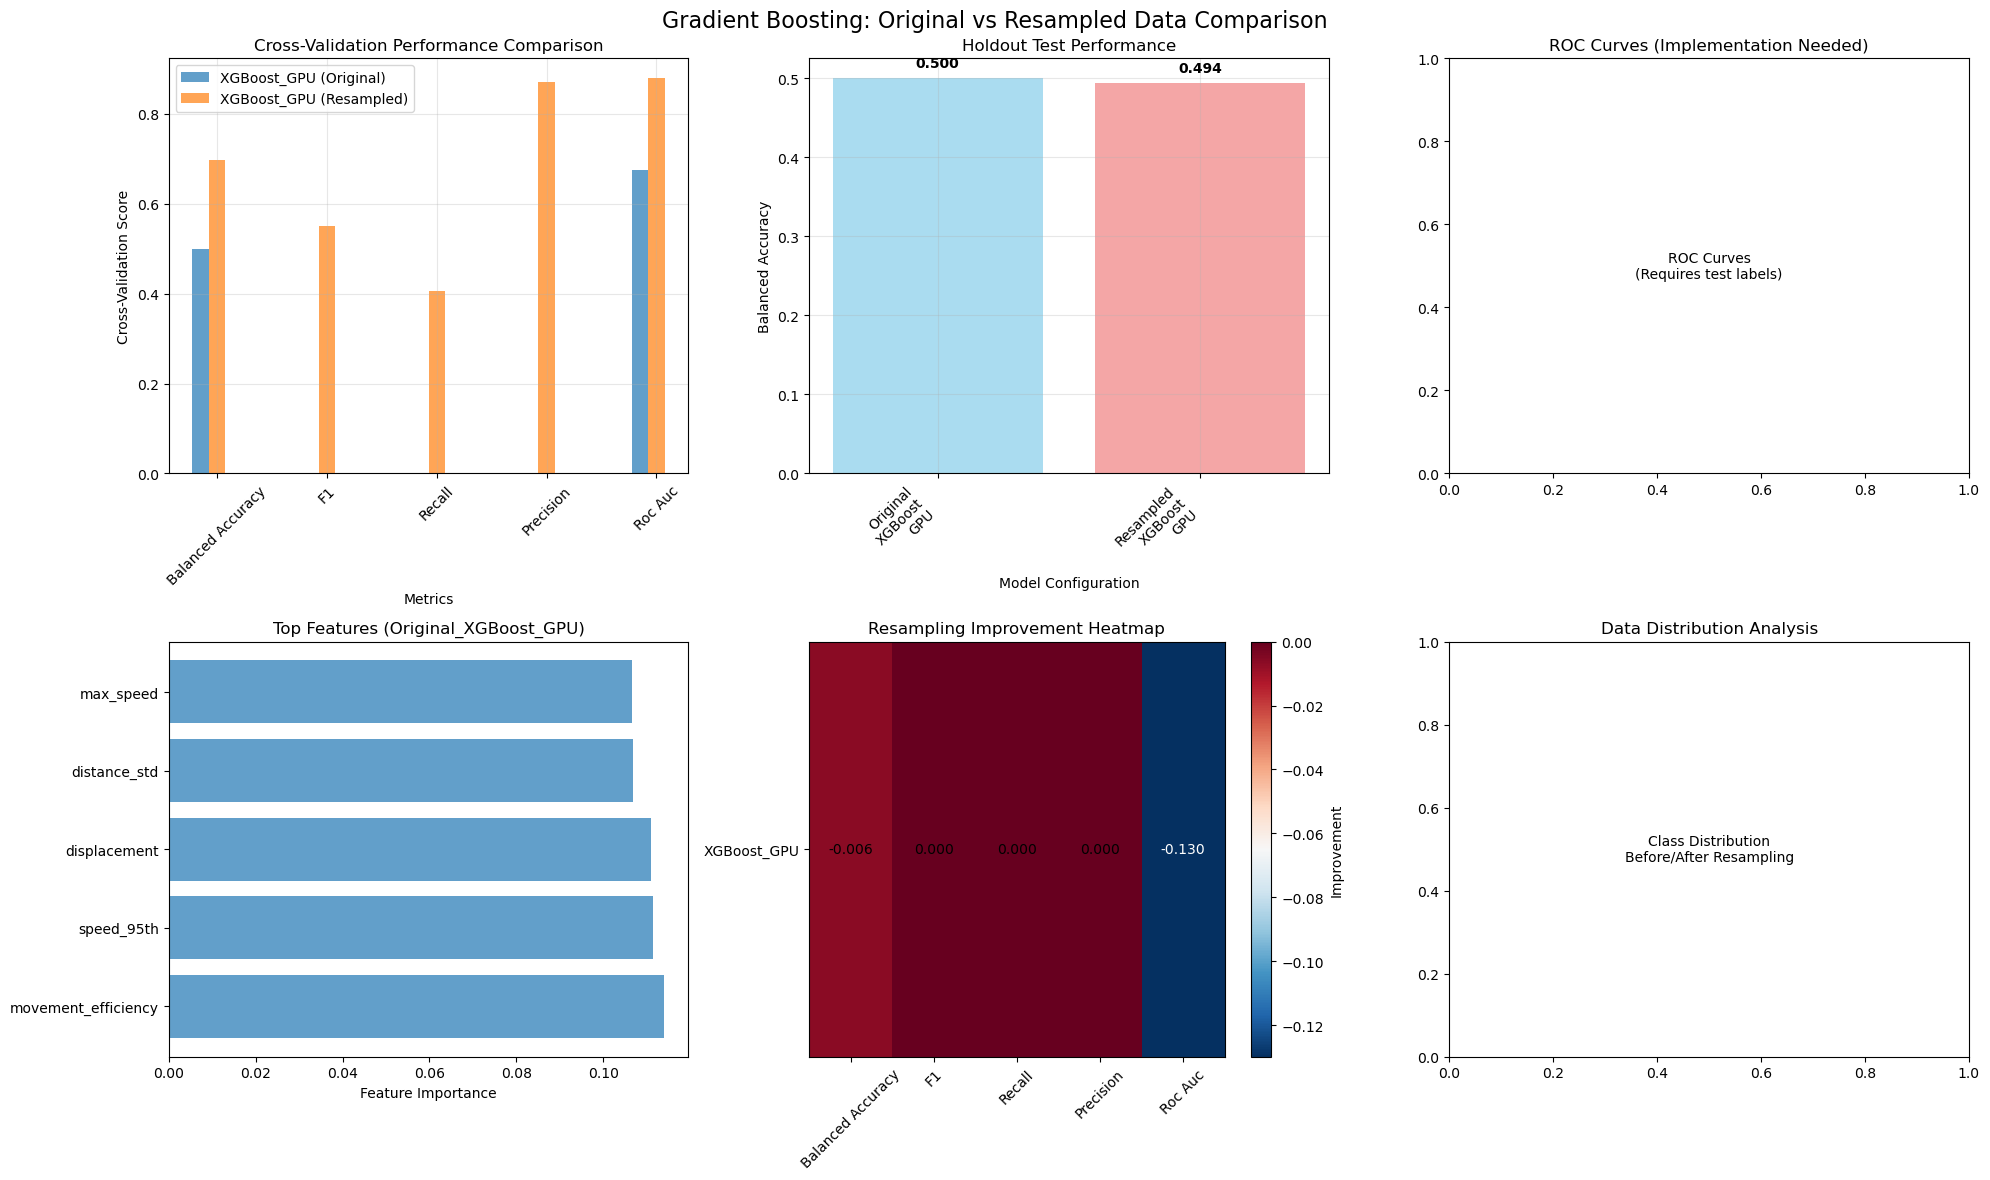

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (classification_report, confusion_matrix, balanced_accuracy_score, 
                           make_scorer, roc_curve, roc_auc_score)
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb

def create_resampling_pipeline(X, y, feature_names, 
                              undersample_ratio=0.01, 
                              oversample_ratio=0.1,
                              smote_k=5):
    """Enhanced resampling pipeline with adaptive parameters for gradient boosting"""
    print("\n ENHANCED RESAMPLING PIPELINE FOR GRADIENT BOOSTING")
    print("="*60)
    
    # Analyze original data
    original_counts = y.value_counts()
    minority_class = original_counts.min()
    majority_class = original_counts.max()
    imbalance_ratio = minority_class / majority_class
    
    print(f"Original class distribution: {original_counts.to_dict()}")
    print(f"Imbalance ratio: {imbalance_ratio:.4f}")
    print(f"Minority class size: {minority_class}")
    
    # Adaptive parameter selection based on data characteristics
    if minority_class < 10:
        print("  Very small minority class - adjusting parameters...")
        oversample_ratio = min(0.2, oversample_ratio)
        smote_k = min(3, minority_class - 1) if minority_class > 1 else 1
    elif minority_class < 50:
        print("  Small minority class - using conservative oversampling...")
        oversample_ratio = min(0.15, oversample_ratio)
        smote_k = min(5, minority_class - 1)
    
    # Adjust undersampling to not be too aggressive
    if undersample_ratio * majority_class < minority_class * 2:
        undersample_ratio = (minority_class * 2) / majority_class
        print(f"Adjusted undersample ratio to: {undersample_ratio:.3f}")
    
    print(f"\nResampling parameters:")
    print(f"  Undersample ratio: {undersample_ratio:.3f}")
    print(f"  Oversample ratio: {oversample_ratio:.3f}")
    print(f"  SMOTE k_neighbors: {smote_k}")
    
    # Create resampling pipeline
    try:
        undersample = RandomUnderSampler(sampling_strategy=undersample_ratio, random_state=42)
        oversample = SMOTE(sampling_strategy=oversample_ratio, k_neighbors=smote_k, random_state=42)
        
        pipeline = ImbPipeline([
            ('undersample', undersample),
            ('oversample', oversample)
        ])
        
        # Apply resampling
        print("\nApplying resampling...")
        X_resampled, y_resampled = pipeline.fit_resample(X, y)
        
        # Report results
        resampled_counts = pd.Series(y_resampled).value_counts()
        print(f"Resampled distribution: {resampled_counts.to_dict()}")
        print(f"New imbalance ratio: {resampled_counts.min() / resampled_counts.max():.4f}")
        print(f"Data size change: {len(X)} → {len(X_resampled)} samples")
        
        return X_resampled, y_resampled, pipeline
        
    except Exception as e:
        print(f" Resampling failed: {str(e)}")
        print("Falling back to original data...")
        return X, y, None

def evaluate_gb_configurations_proper_validation(X, y, feature_names, 
                                                test_size=0.2, 
                                                resampling_params=None):
    """
    Comprehensive Gradient Boosting evaluation with PROPER validation:
    - Split data first
    - Resample only training data
    - Test on original holdout data
    """
    print("\n COMPREHENSIVE XGBOOST GPU ANALYSIS WITH PROPER VALIDATION")
    print("="*80)
    
    # Default resampling parameters
    if resampling_params is None:
        resampling_params = {
            'undersample_ratio': 0.02,
            'oversample_ratio': 0.15,
            'smote_k': 5
        }
    
    # Define models with your specified parameters
    models = {
        'XGBoost_GPU': xgb.XGBClassifier(
            n_estimators=100,        # Moderate number of estimators
            learning_rate=0.1,       # Standard learning rate
            max_depth=4,             # Slightly deeper for XGBoost
            min_child_weight=3,      # Regularization for small datasets
            subsample=0.8,           # Stochastic sampling
            colsample_bytree=0.8,    # Feature sampling for regularization
            reg_alpha=0.1,           # L1 regularization
            reg_lambda=1.0,          # L2 regularization
            device='cuda',           # GPU acceleration
            random_state=42
        )
    }
    
    # Step 1: Split original data FIRST (this is crucial!)
    print(" Splitting original data into train/test...")
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    print(f"Original train set: {len(X_train_orig)} samples")
    print(f"  Class distribution: {pd.Series(y_train_orig).value_counts().to_dict()}")
    print(f"Original test set: {len(X_test_orig)} samples")
    print(f"  Class distribution: {pd.Series(y_test_orig).value_counts().to_dict()}")
    
    # Step 2: Create resampled training data
    print("\n Creating resampled training data...")
    X_train_resampled, y_train_resampled, resampling_pipeline = create_resampling_pipeline(
        X_train_orig, y_train_orig, feature_names, **resampling_params
    )
    
    # Step 3: Cross-validation setup
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    results = {
        'cross_validation': {
            'original_train': {},
            'resampled_train': {}
        },
        'holdout_test': {},
        'feature_importance': {}
    }
    
    # Step 4: Cross-validation on training sets
    print("\n CROSS-VALIDATION ON TRAINING DATA")
    print("="*50)
    
    # CV on original training data
    print("\n Cross-validation on ORIGINAL training data:")
    for model_name, model in models.items():
        print(f"\n Evaluating {model_name}...")
        
        try:
            # Multiple metrics for comprehensive evaluation
            cv_balanced = cross_val_score(model, X_train_orig, y_train_orig, 
                                        cv=cv, scoring=make_scorer(balanced_accuracy_score))
            cv_f1 = cross_val_score(model, X_train_orig, y_train_orig, cv=cv, scoring='f1')
            cv_recall = cross_val_score(model, X_train_orig, y_train_orig, cv=cv, scoring='recall')
            cv_precision = cross_val_score(model, X_train_orig, y_train_orig, cv=cv, scoring='precision')
            cv_roc_auc = cross_val_score(model, X_train_orig, y_train_orig, cv=cv, scoring='roc_auc')
            
            results['cross_validation']['original_train'][model_name] = {
                'balanced_accuracy': cv_balanced.mean(),
                'balanced_accuracy_std': cv_balanced.std(),
                'f1': cv_f1.mean(),
                'f1_std': cv_f1.std(),
                'recall': cv_recall.mean(),
                'recall_std': cv_recall.std(),
                'precision': cv_precision.mean(),
                'precision_std': cv_precision.std(),
                'roc_auc': cv_roc_auc.mean(),
                'roc_auc_std': cv_roc_auc.std(),
                'model_type': model_name
            }
            
            print(f"  Balanced Accuracy: {cv_balanced.mean():.3f} ± {cv_balanced.std():.3f}")
            print(f"  F1 Score: {cv_f1.mean():.3f} ± {cv_f1.std():.3f}")
            print(f"  Recall: {cv_recall.mean():.3f} ± {cv_recall.std():.3f}")
            print(f"  Precision: {cv_precision.mean():.3f} ± {cv_precision.std():.3f}")
            print(f"  ROC AUC: {cv_roc_auc.mean():.3f} ± {cv_roc_auc.std():.3f}")
            
        except Exception as e:
            print(f"  Error: {str(e)}")
            results['cross_validation']['original_train'][model_name] = {'error': str(e)}

    # CV on resampled training data
    if resampling_pipeline is not None:
        print("\n Cross-validation on RESAMPLED training data:")
        for model_name, model in models.items():
            print(f"\n Evaluating {model_name}...")
            
            try:
                cv_balanced = cross_val_score(model, X_train_resampled, y_train_resampled, 
                                            cv=cv, scoring=make_scorer(balanced_accuracy_score))
                cv_f1 = cross_val_score(model, X_train_resampled, y_train_resampled, cv=cv, scoring='f1')
                cv_recall = cross_val_score(model, X_train_resampled, y_train_resampled, cv=cv, scoring='recall')
                cv_precision = cross_val_score(model, X_train_resampled, y_train_resampled, cv=cv, scoring='precision')
                cv_roc_auc = cross_val_score(model, X_train_resampled, y_train_resampled, cv=cv, scoring='roc_auc')
                
                results['cross_validation']['resampled_train'][model_name] = {
                    'balanced_accuracy': cv_balanced.mean(),
                    'balanced_accuracy_std': cv_balanced.std(),
                    'f1': cv_f1.mean(),
                    'f1_std': cv_f1.std(),
                    'recall': cv_recall.mean(),
                    'recall_std': cv_recall.std(),
                    'precision': cv_precision.mean(),
                    'precision_std': cv_precision.std(),
                    'roc_auc': cv_roc_auc.mean(),
                    'roc_auc_std': cv_roc_auc.std(),
                    'model_type': model_name
                }
                
                print(f"  Balanced Accuracy: {cv_balanced.mean():.3f} ± {cv_balanced.std():.3f}")
                print(f"  F1 Score: {cv_f1.mean():.3f} ± {cv_f1.std():.3f}")
                print(f"  Recall: {cv_recall.mean():.3f} ± {cv_recall.std():.3f}")
                print(f"  Precision: {cv_precision.mean():.3f} ± {cv_precision.std():.3f}")
                print(f"  ROC AUC: {cv_roc_auc.mean():.3f} ± {cv_roc_auc.std():.3f}")
                
            except Exception as e:
                print(f"  Error: {str(e)}")
                results['cross_validation']['resampled_train'][model_name] = {'error': str(e)}

    # Step 5: Final evaluation on original holdout test set
    print("\n FINAL EVALUATION ON ORIGINAL HOLDOUT TEST SET")
    print("="*60)
    
    # Find best configurations from CV
    orig_cv_results = results['cross_validation']['original_train']
    resamp_cv_results = results['cross_validation']['resampled_train']
    
    # Test models on original holdout test set
    configs_to_test = []
    
    # Add original models
    for model_name in models.keys():
        if model_name in orig_cv_results and 'error' not in orig_cv_results[model_name]:
            configs_to_test.append(('Original_' + model_name, model_name, X_train_orig, y_train_orig))
    
    # Add resampled models
    if resampling_pipeline is not None:
        for model_name in models.keys():
            if model_name in resamp_cv_results and 'error' not in resamp_cv_results[model_name]:
                configs_to_test.append(('Resampled_' + model_name, model_name, X_train_resampled, y_train_resampled))
    
    best_model = None
    best_model_name = None
    best_score = 0
    
    for test_name, model_name, X_train, y_train in configs_to_test:
        print(f"\n Testing {test_name} on original holdout test set...")
        
        try:
            # Create and train model
            model = models[model_name]
            model.fit(X_train, y_train)
            
            # Predict on original test set
            y_pred = model.predict(X_test_orig)
            y_pred_proba = model.predict_proba(X_test_orig)[:, 1]
            
            # Calculate metrics
            bal_acc = balanced_accuracy_score(y_test_orig, y_pred)
            roc_auc = roc_auc_score(y_test_orig, y_pred_proba)
            
            # Classification report
            report = classification_report(y_test_orig, y_pred, output_dict=True, zero_division=0)
            
            results['holdout_test'][test_name] = {
                'model_name': model_name,
                'balanced_accuracy': bal_acc,
                'roc_auc': roc_auc,
                'precision': report['1']['precision'] if '1' in report else 0,
                'recall': report['1']['recall'] if '1' in report else 0,
                'f1': report['1']['f1-score'] if '1' in report else 0,
                'model': model,
                'predictions': y_pred,
                'probabilities': y_pred_proba
            }
            
            # Feature importance
            if hasattr(model, 'feature_importances_'):
                importance_df = pd.DataFrame({
                    'feature': feature_names,
                    'importance': model.feature_importances_
                }).sort_values('importance', ascending=False)
                
                results['feature_importance'][test_name] = importance_df
                
                print(f"  Top 3 features: {', '.join(importance_df.head(3)['feature'].tolist())}")
            
            print(f"  Balanced Accuracy: {bal_acc:.3f}")
            print(f"  ROC AUC: {roc_auc:.3f}")
            print(f"  Precision: {results['holdout_test'][test_name]['precision']:.3f}")
            print(f"  Recall: {results['holdout_test'][test_name]['recall']:.3f}")
            print(f"  F1 Score: {results['holdout_test'][test_name]['f1']:.3f}")
            
            # Update best model
            if bal_acc > best_score:
                best_model = model
                best_model_name = test_name
                best_score = bal_acc
            
        except Exception as e:
            print(f"  Error: {e}")
            results['holdout_test'][test_name] = {'error': str(e)}
    
    # Step 6: Analysis and visualization
    print("\n COMPREHENSIVE ANALYSIS")
    print("="*50)
    
    # Model comparison
    holdout_results = results['holdout_test']
    valid_results = {k: v for k, v in holdout_results.items() if 'error' not in v}
    
    if len(valid_results) >= 2:
        print("\n PERFORMANCE COMPARISON ON ORIGINAL HOLDOUT TEST SET:")
        
        comparison_df = pd.DataFrame({
            name: {
                'Balanced Accuracy': result['balanced_accuracy'],
                'ROC AUC': result['roc_auc'],
                'Precision': result['precision'],
                'Recall': result['recall'],
                'F1 Score': result['f1']
            } for name, result in valid_results.items()
        }).T
        
        print(comparison_df.round(3))
        
        # Calculate improvements from resampling
        print("\n RESAMPLING IMPROVEMENTS:")
        for model_name in models.keys():
            orig_key = f'Original_{model_name}'
            resamp_key = f'Resampled_{model_name}'
            
            if orig_key in valid_results and resamp_key in valid_results:
                orig_result = valid_results[orig_key]
                resamp_result = valid_results[resamp_key]
                
                print(f"\n {model_name}:")
                print(f"  Balanced Accuracy: {resamp_result['balanced_accuracy'] - orig_result['balanced_accuracy']:+.3f}")
                print(f"  Recall: {resamp_result['recall'] - orig_result['recall']:+.3f}")
                print(f"  F1 Score: {resamp_result['f1'] - orig_result['f1']:+.3f}")
                print(f"  ROC AUC: {resamp_result['roc_auc'] - orig_result['roc_auc']:+.3f}")
    
    print(f"\n FINAL BEST MODEL: {best_model_name}")
    if best_model_name and best_model_name in holdout_results:
        best_config = holdout_results[best_model_name]
        print(f"  Model Type: {best_config['model_name']}")
        print(f"  Balanced Accuracy: {best_config['balanced_accuracy']:.3f}")
        print(f"  ROC AUC: {best_config['roc_auc']:.3f}")
    
    return results, best_model, best_model_name, resampling_pipeline

def plot_gb_comparison_results(results):
    """Create comprehensive visualizations of gradient boosting comparison"""
    print("\n Creating comprehensive comparison visualizations...")
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Gradient Boosting: Original vs Resampled Data Comparison', fontsize=16)
    
    # Plot 1: Cross-validation comparison
    ax = axes[0, 0]
    cv_orig = results['cross_validation']['original_train']
    cv_resamp = results['cross_validation']['resampled_train']
    
    metrics = ['balanced_accuracy', 'f1', 'recall', 'precision', 'roc_auc']
    model_names = list(cv_orig.keys())
    
    x = np.arange(len(metrics))
    width = 0.15
    
    for i, model_name in enumerate(model_names):
        if 'error' not in cv_orig.get(model_name, {}):
            orig_scores = [cv_orig[model_name].get(metric, 0) for metric in metrics]
            ax.bar(x + i*width, orig_scores, width, label=f'{model_name} (Original)', alpha=0.7)
        
        if model_name in cv_resamp and 'error' not in cv_resamp[model_name]:
            resamp_scores = [cv_resamp[model_name].get(metric, 0) for metric in metrics]
            ax.bar(x + (i+len(model_names))*width, resamp_scores, width, 
                  label=f'{model_name} (Resampled)', alpha=0.7)
    
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Cross-Validation Score')
    ax.set_title('Cross-Validation Performance Comparison')
    ax.set_xticks(x + width)
    ax.set_xticklabels([m.replace('_', ' ').title() for m in metrics], rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Holdout test results
    ax = axes[0, 1]
    holdout_results = results['holdout_test']
    valid_holdout = {k: v for k, v in holdout_results.items() if 'error' not in v}
    
    if valid_holdout:
        names = list(valid_holdout.keys())
        bal_acc_scores = [valid_holdout[name]['balanced_accuracy'] for name in names]
        colors = ['skyblue' if 'Original' in name else 'lightcoral' for name in names]
        
        bars = ax.bar(range(len(names)), bal_acc_scores, color=colors, alpha=0.7)
        ax.set_xlabel('Model Configuration')
        ax.set_ylabel('Balanced Accuracy')
        ax.set_title('Holdout Test Performance')
        ax.set_xticks(range(len(names)))
        ax.set_xticklabels([name.replace('_', '\n') for name in names], rotation=45, ha='right')
        
        # Add score labels on bars
        for bar, score in zip(bars, bal_acc_scores):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    
    ax.grid(True, alpha=0.3)
    
    # Plot 3: ROC Curves
    ax = axes[0, 2]
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
    
    for i, (name, result) in enumerate(valid_holdout.items()):
        if 'probabilities' in result:
            # Assuming y_test_orig is available (you might need to pass it)
            # For now, we'll skip ROC curves or you can modify to include test data
            pass
    
    ax.set_title('ROC Curves (Implementation Needed)')
    ax.text(0.5, 0.5, 'ROC Curves\n(Requires test labels)', ha='center', va='center', 
            transform=ax.transAxes)
    
    # Plot 4: Feature importance comparison
    ax = axes[1, 0]
    feature_importance = results.get('feature_importance', {})
    
    if len(feature_importance) >= 2:
        # Compare top features between original and resampled models
        first_model = list(feature_importance.keys())[0]
        top_features = feature_importance[first_model].head(5)
        
        ax.barh(range(len(top_features)), top_features['importance'], alpha=0.7)
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features['feature'])
        ax.set_xlabel('Feature Importance')
        ax.set_title(f'Top Features ({first_model})')
    else:
        ax.text(0.5, 0.5, 'Feature Importance\nAnalysis', ha='center', va='center',
                transform=ax.transAxes)
    
    # Plot 5: Metric improvement heatmap
    ax = axes[1, 1]
    improvement_data = []
    improvement_labels = []
    
    for model_name in ['XGBoost_GPU']:
        orig_key = f'Original_{model_name}'
        resamp_key = f'Resampled_{model_name}'
        
        if orig_key in valid_holdout and resamp_key in valid_holdout:
            orig_result = valid_holdout[orig_key]
            resamp_result = valid_holdout[resamp_key]
            
            improvements = [
                resamp_result['balanced_accuracy'] - orig_result['balanced_accuracy'],
                resamp_result['f1'] - orig_result['f1'],
                resamp_result['recall'] - orig_result['recall'],
                resamp_result['precision'] - orig_result['precision'],
                resamp_result['roc_auc'] - orig_result['roc_auc']
            ]
            improvement_data.append(improvements)
            improvement_labels.append(model_name)
    
    if improvement_data:
        improvement_array = np.array(improvement_data)
        im = ax.imshow(improvement_array, cmap='RdBu_r', aspect='auto')
        
        ax.set_xticks(range(len(metrics)))
        ax.set_xticklabels([m.replace('_', ' ').title() for m in metrics], rotation=45)
        ax.set_yticks(range(len(improvement_labels)))
        ax.set_yticklabels(improvement_labels)
        ax.set_title('Resampling Improvement Heatmap')
        
        # Add text annotations
        for i in range(len(improvement_labels)):
            for j in range(len(metrics)):
                text = ax.text(j, i, f'{improvement_array[i, j]:.3f}',
                              ha="center", va="center", color="white" if abs(improvement_array[i, j]) > 0.1 else "black")
        
        plt.colorbar(im, ax=ax, label='Improvement')
    
    # Plot 6: Class distribution comparison
    ax = axes[1, 2]
    ax.text(0.5, 0.5, 'Class Distribution\nBefore/After Resampling', ha='center', va='center',
            transform=ax.transAxes)
    ax.set_title('Data Distribution Analysis')
    
    plt.tight_layout()
    plt.show()

# Usage functions
def run_comprehensive_gb_analysis(X_scaled, y, feature_names):
    """Run the complete gradient boosting analysis with proper validation"""
    return evaluate_gb_configurations_proper_validation(X_scaled, y, feature_names)

def run_custom_gb_resampling_analysis(X_scaled, y, feature_names):
    """Run with custom resampling parameters"""
    custom_params = {
        'undersample_ratio': 0.02,  # Less aggressive undersampling
        'oversample_ratio': 0.15,   # More conservative oversampling
        'smote_k': 3                # Lower K for SMOTE
    }
    
    return evaluate_gb_configurations_proper_validation(
        X_scaled, y, feature_names, resampling_params=custom_params
    )

# Final usage:
results, best_model, best_model_name, pipeline = run_comprehensive_gb_analysis(X_scaled, y, feature_names)
plot_gb_comparison_results(results)

In [19]:
summary = generate_small_dataset_summary(results, best_model_name, X_scaled, y, feature_names)

 SUMMARY - SMALL DATASET COLLISION ANALYSIS
 Dataset Characteristics:
   - Total samples: 266960
   -  Injury samples: 104.0 (0.0%)
   -  Normal samples: 266856.0 (100.0%)
   -  Features analyzed: 10



 XGBOOST GPU HYPERPARAMETER EXPLORATION...
 Testing 5 parameter types with dataset: 266960 samples, 10 features

 Evaluating Learning Rate (Shrinkage)...
   learning_rate=0.01: 0.500 ± 0.000
   learning_rate=0.05: 0.500 ± 0.000
   learning_rate=0.1: 0.500 ± 0.000
   learning_rate=0.15: 0.500 ± 0.000
   learning_rate=0.2: 0.500 ± 0.000
   learning_rate=0.3: 0.500 ± 0.000

 Evaluating Number of Boosting Rounds...
   n_estimators=25: 0.500 ± 0.000
   n_estimators=50: 0.500 ± 0.000
   n_estimators=75: 0.500 ± 0.000
   n_estimators=100: 0.500 ± 0.000
   n_estimators=150: 0.500 ± 0.000
   n_estimators=200: 0.500 ± 0.000
   n_estimators=300: 0.500 ± 0.000

 Evaluating Maximum Tree Depth...
   max_depth=2: 0.500 ± 0.000
   max_depth=3: 0.500 ± 0.000
   max_depth=4: 0.500 ± 0.000
   max_depth=5: 0.500 ± 0.000
   max_depth=6: 0.500 ± 0.000
   max_depth=8: 0.500 ± 0.000

 Evaluating Feature Sampling Ratio...
   colsample_bytree=0.6: 0.500 ± 0.000
   colsample_bytree=0.7: 0.500 ± 0.000
   colsamp

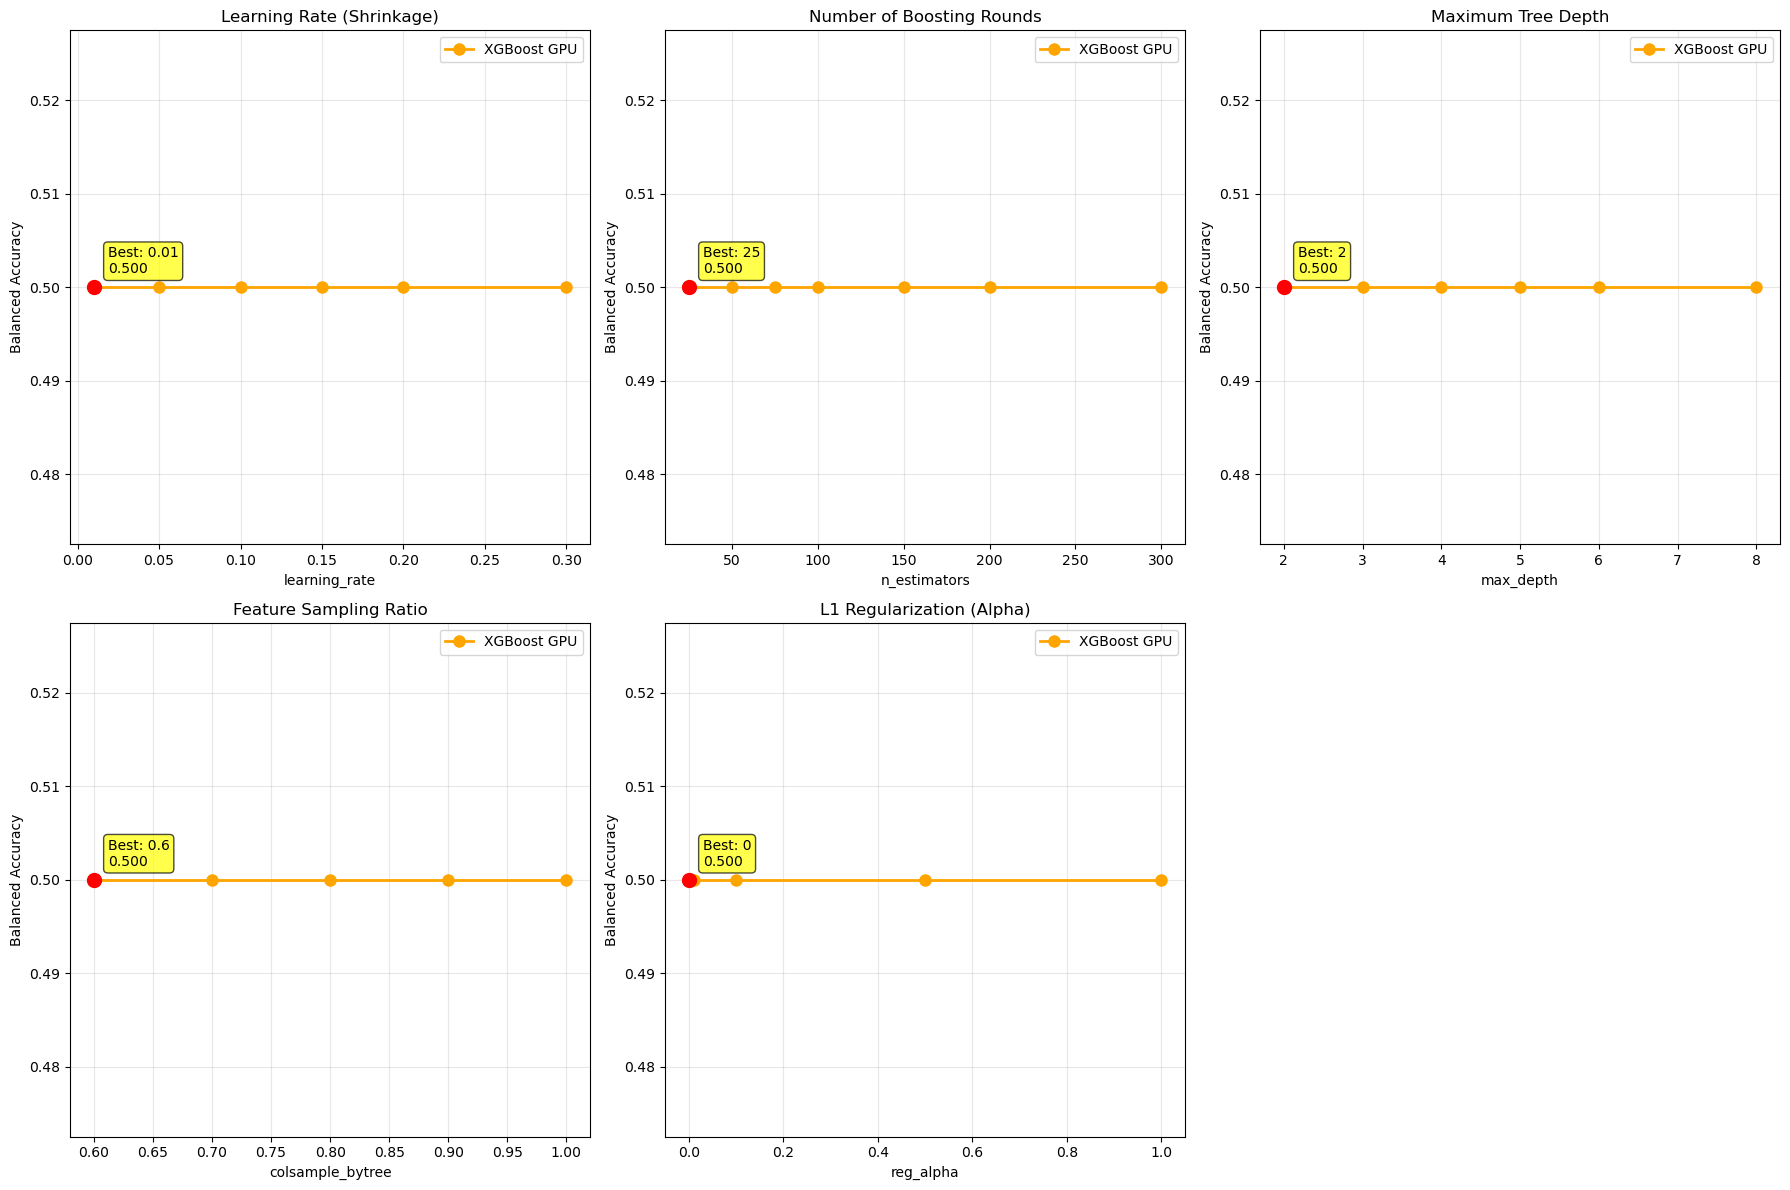


 Creating XGBoost parameter performance heatmap...


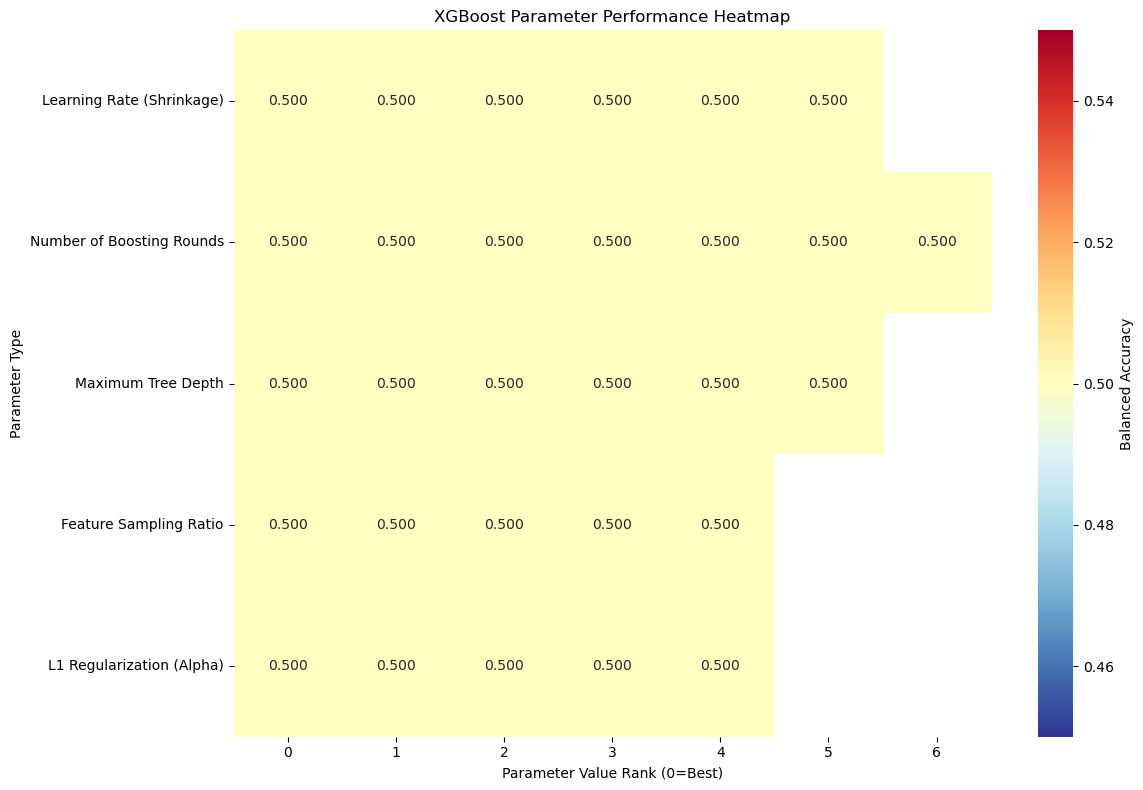


 COMPREHENSIVE XGBOOST GRID SEARCH OPTIMIZATION...
 Grid search with refined parameters:
   learning_rate: [0.01, 0.05, 0.1]
   n_estimators: [25, 50, 75]
   max_depth: [2, 3, 4]
   colsample_bytree: [0.6, 0.7, 0.8]
   reg_alpha: [0, 0.01, 0.1]
Fitting 3 folds for each of 243 candidates, totalling 729 fits

 Grid Search Results:
   Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 25, 'reg_alpha': 0}
   Best Score: 0.500


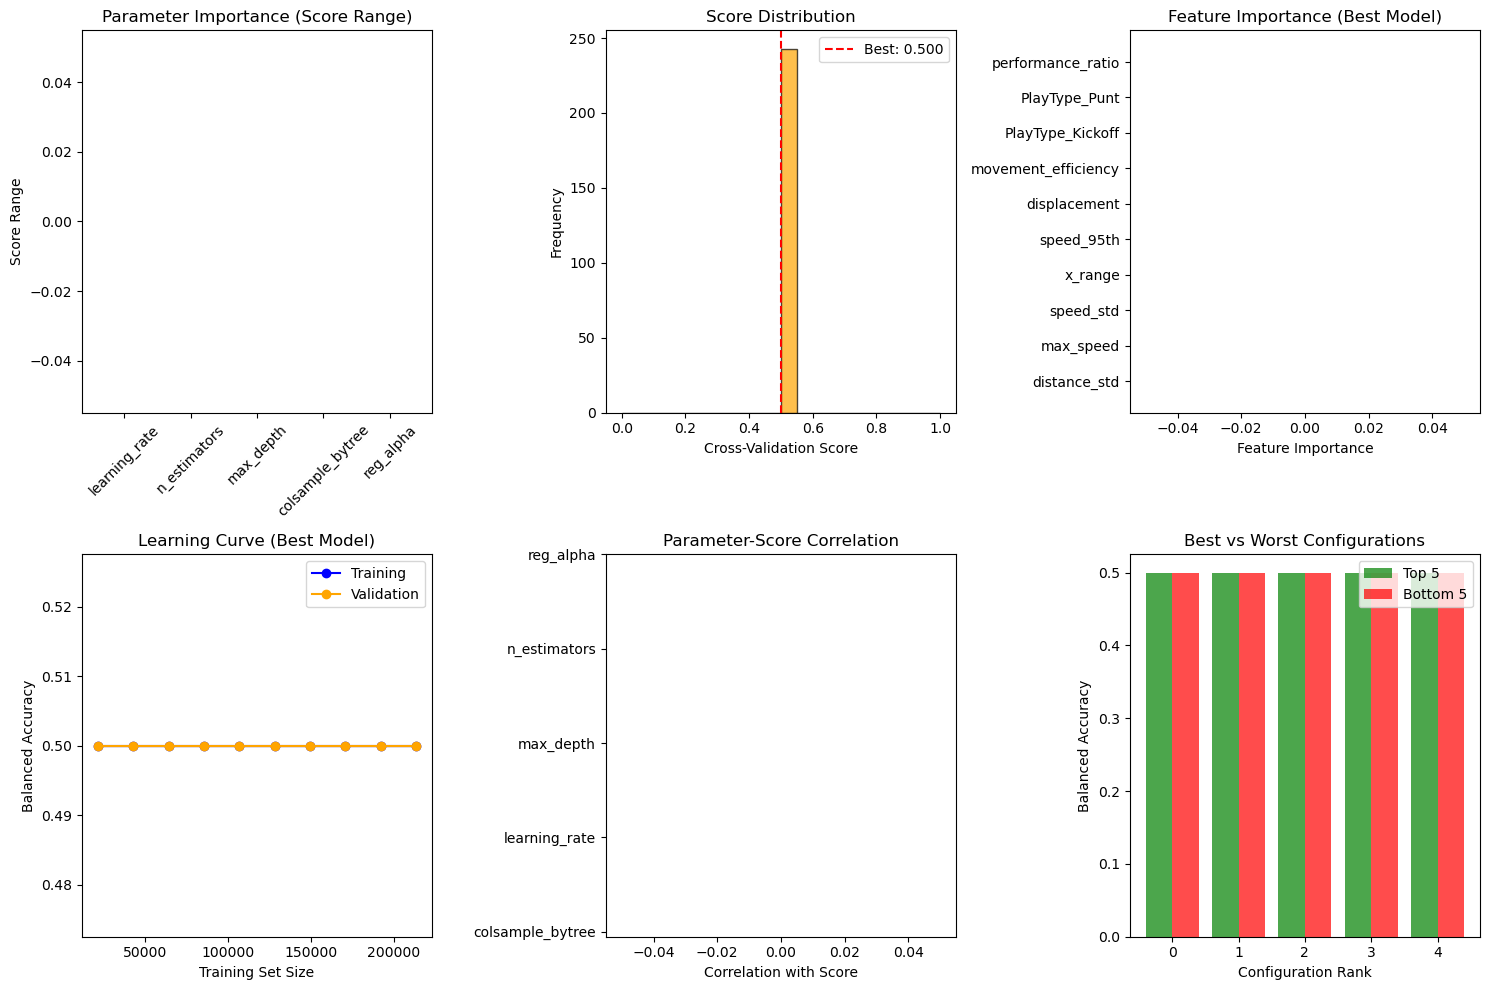


 COMPREHENSIVE XGBOOST GPU ANALYSIS SUMMARY

  TOP PARAMETER CONFIGURATIONS:
   1. Learning Rate (Shrinkage) = 0.01: 0.500 ± 0.000
   2. Learning Rate (Shrinkage) = 0.05: 0.500 ± 0.000
   3. Learning Rate (Shrinkage) = 0.1: 0.500 ± 0.000
   4. Learning Rate (Shrinkage) = 0.15: 0.500 ± 0.000
   5. Learning Rate (Shrinkage) = 0.2: 0.500 ± 0.000
   6. Learning Rate (Shrinkage) = 0.3: 0.500 ± 0.000
   7. Number of Boosting Rounds = 25: 0.500 ± 0.000
   8. Number of Boosting Rounds = 50: 0.500 ± 0.000
   9. Number of Boosting Rounds = 75: 0.500 ± 0.000
   10. Number of Boosting Rounds = 100: 0.500 ± 0.000

 🔍 KEY INSIGHTS:
   • Best Learning Rate (Shrinkage): 0.01 (Score: 0.500)
   • Best Number of Boosting Rounds: 25 (Score: 0.500)
   • Best Maximum Tree Depth: 2 (Score: 0.500)
   • Best Feature Sampling Ratio: 0.6 (Score: 0.500)
   • Best L1 Regularization (Alpha): 0 (Score: 0.500)

 💡 GRID SEARCH OPTIMIZATION:
   • Best Combined Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.0

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (StratifiedKFold, cross_val_score, learning_curve, 
                                   validation_curve, GridSearchCV)
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, 
                           roc_auc_score, balanced_accuracy_score, make_scorer)
import xgboost as xgb

def evaluate_xgboost_hyperparameters(X, y, feature_names):
    """Comprehensive XGBoost GPU hyperparameter exploration"""
    print("\n XGBOOST GPU HYPERPARAMETER EXPLORATION...")
    
    # XGBoost parameter grids for exploration
    xgb_parameter_sets = {
        'learning_rate': {
            'param_name': 'learning_rate',
            'param_values': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
            'description': 'Learning Rate (Shrinkage)'
        },
        'n_estimators': {
            'param_name': 'n_estimators',
            'param_values': [25, 50, 75, 100, 150, 200, 300],
            'description': 'Number of Boosting Rounds'
        },
        'max_depth': {
            'param_name': 'max_depth',
            'param_values': [2, 3, 4, 5, 6, 8],
            'description': 'Maximum Tree Depth'
        },
        'colsample_bytree': {
            'param_name': 'colsample_bytree',
            'param_values': [0.6, 0.7, 0.8, 0.9, 1.0],
            'description': 'Feature Sampling Ratio'
        },
        'reg_alpha': {
            'param_name': 'reg_alpha',
            'param_values': [0, 0.01, 0.1, 0.5, 1.0],
            'description': 'L1 Regularization (Alpha)'
        }
  

    }
    
    results = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    print(f" Testing {len(xgb_parameter_sets)} parameter types with dataset: {len(X)} samples, {X.shape[1]} features")
    
    for param_set_name, param_config in xgb_parameter_sets.items():
        print(f"\n Evaluating {param_config['description']}...")
        
        param_results = {}
        
        for param_value in param_config['param_values']:
            # Base XGBoost configuration
            base_params = {
                'n_estimators': 100,
                'learning_rate': 0.1,
                'max_depth': 4,
                'min_child_weight': 3,
                'subsample': 0.8,
                'colsample_bytree': 0.8,
                'reg_alpha': 0.1,
                'reg_lambda': 1.0,
                'device': 'cuda',
                'random_state': 42
            }
            
            # Update with current parameter being tested
            base_params[param_config['param_name']] = param_value
            
            try:
                model = xgb.XGBClassifier(**base_params)
                
                # Cross-validation scores
                cv_scores = cross_val_score(model, X, y, cv=cv, scoring='balanced_accuracy')
                
                param_results[param_value] = {
                    'mean_score': cv_scores.mean(),
                    'std_score': cv_scores.std(),
                    'model': model
                }
                
                print(f"   {param_config['param_name']}={param_value}: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
                
            except Exception as e:
                print(f"   {param_config['param_name']}={param_value}: Error - {str(e)}")
                param_results[param_value] = {'error': str(e)}
        
        results[param_set_name] = {
            'config': param_config,
            'results': param_results
        }
    
    return results

def plot_xgboost_parameter_exploration(xgb_results):
    """Create comprehensive visualization of XGBoost parameter exploration"""
    print("\n Creating XGBoost parameter exploration visualizations...")
    
    n_params = len(xgb_results)
    n_cols = 3
    n_rows = (n_params + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    plot_idx = 0
    
    for param_name, param_data in xgb_results.items():
        row = plot_idx // n_cols
        col = plot_idx % n_cols
        ax = axes[row, col]
        
        # Extract data for plotting (excluding error results)
        valid_results = {k: v for k, v in param_data['results'].items() if 'error' not in v}
        
        if valid_results:
            param_values = list(valid_results.keys())
            means = [valid_results[val]['mean_score'] for val in param_values]
            stds = [valid_results[val]['std_score'] for val in param_values]
            
            # Plot line with error bars
            ax.plot(param_values, means, 'o-', linewidth=2, markersize=8, 
                   label='XGBoost GPU', color='orange')
            ax.fill_between(param_values, 
                           [m - s for m, s in zip(means, stds)],
                           [m + s for m, s in zip(means, stds)],
                           alpha=0.3, color='orange')
            
            # Highlight best value
            best_idx = np.argmax(means)
            best_val = param_values[best_idx]
            best_score = means[best_idx]
            ax.scatter([best_val], [best_score], color='red', s=100, zorder=5)
            ax.annotate(f'Best: {best_val}\n{best_score:.3f}', 
                       xy=(best_val, best_score), xytext=(10, 10),
                       textcoords='offset points', ha='left',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
        else:
            ax.text(0.5, 0.5, 'All parameter\nvalues failed', ha='center', va='center',
                   transform=ax.transAxes)
        
        ax.set_xlabel(param_data['config']['param_name'])
        ax.set_ylabel('Balanced Accuracy')
        ax.set_title(param_data['config']['description'])
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        plot_idx += 1
    
    # Hide unused subplots
    for i in range(plot_idx, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def create_xgboost_heatmap_analysis(xgb_results):
    """Create heatmap showing XGBoost parameter performance"""
    print("\n Creating XGBoost parameter performance heatmap...")
    
    # Extract best parameters and scores for each parameter type
    best_params = {}
    param_scores = {}
    
    for param_name, param_data in xgb_results.items():
        valid_results = {k: v for k, v in param_data['results'].items() if 'error' not in v}
        
        if valid_results:
            scores = [(val, data['mean_score']) for val, data in valid_results.items()]
            scores.sort(key=lambda x: x[1], reverse=True)
            
            best_params[param_name] = scores[0][0]
            param_scores[param_name] = [score[1] for score in scores]
    
    if param_scores:
        # Create heatmap data
        param_names = list(param_scores.keys())
        heatmap_data = []
        
        for param_name in param_names:
            row_data = param_scores[param_name]
            heatmap_data.append(row_data)
        
        # Find max length for padding
        max_len = max(len(row) for row in heatmap_data)
        for i, row in enumerate(heatmap_data):
            while len(row) < max_len:
                row.append(np.nan)
        
        heatmap_data = np.array(heatmap_data)
        
        plt.figure(figsize=(12, 8))
        mask = np.isnan(heatmap_data)
        sns.heatmap(heatmap_data, 
                    yticklabels=[xgb_results[name]['config']['description'] for name in param_names],
                    cmap='RdYlBu_r',
                    mask=mask,
                    annot=True, 
                    fmt='.3f',
                    cbar_kws={'label': 'Balanced Accuracy'})
        
        plt.title('XGBoost Parameter Performance Heatmap')
        plt.xlabel('Parameter Value Rank (0=Best)')
        plt.ylabel('Parameter Type')
        plt.tight_layout()
        plt.show()
    
    return best_params

def perform_xgboost_grid_search(X, y, xgb_results, feature_names):
    """Perform grid search using insights from XGBoost parameter exploration"""
    print("\n COMPREHENSIVE XGBOOST GRID SEARCH OPTIMIZATION...")
    
    # Extract top-performing parameter ranges
    refined_params = {}
    
    for param_name, param_data in xgb_results.items():
        valid_results = {k: v for k, v in param_data['results'].items() if 'error' not in v}
        
        if valid_results:
            # Get top 3 performing values for each parameter
            scores = [(val, data['mean_score']) for val, data in valid_results.items()]
            scores.sort(key=lambda x: x[1], reverse=True)
            top_values = [score[0] for score in scores[:3]]
            
            param_key = param_data['config']['param_name']
            refined_params[param_key] = top_values
    
    if refined_params:
        print(f" Grid search with refined parameters:")
        for param, values in refined_params.items():
            print(f"   {param}: {values}")
        
        # Perform grid search
        xgb_model = xgb.XGBClassifier(device='cuda', random_state=42)
        grid_search = GridSearchCV(
            xgb_model,
            refined_params,
            cv=3,
            scoring='balanced_accuracy',
            n_jobs=1,  # Use 1 job for GPU to avoid conflicts
            verbose=1
        )
        
        grid_search.fit(X, y)
        
        print(f"\n Grid Search Results:")
        print(f"   Best Parameters: {grid_search.best_params_}")
        print(f"   Best Score: {grid_search.best_score_:.3f}")
        
        # Analyze results
        results_df = pd.DataFrame(grid_search.cv_results_)
        
        plt.figure(figsize=(15, 10))
        
        # Plot parameter importance
        param_importance = {}
        for param in refined_params.keys():
            param_col = f'param_{param}'
            if param_col in results_df.columns:
                grouped = results_df.groupby(param_col)['mean_test_score'].agg(['mean', 'std'])
                param_importance[param] = grouped['mean'].max() - grouped['mean'].min()
        
        # Plot 1: Parameter importance
        plt.subplot(2, 3, 1)
        if param_importance:
            params = list(param_importance.keys())
            importance = list(param_importance.values())
            plt.bar(params, importance, color='orange', alpha=0.7)
            plt.title('Parameter Importance (Score Range)')
            plt.xticks(rotation=45)
            plt.ylabel('Score Range')
        
        # Plot 2: Score distribution
        plt.subplot(2, 3, 2)
        plt.hist(results_df['mean_test_score'], bins=20, alpha=0.7, edgecolor='black', color='orange')
        plt.axvline(grid_search.best_score_, color='red', linestyle='--', 
                    label=f'Best: {grid_search.best_score_:.3f}')
        plt.xlabel('Cross-Validation Score')
        plt.ylabel('Frequency')
        plt.title('Score Distribution')
        plt.legend()
        
        # Plot 3: Feature importance from best model
        plt.subplot(2, 3, 3)
        best_model = grid_search.best_estimator_
        if hasattr(best_model, 'feature_importances_'):
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': best_model.feature_importances_
            }).sort_values('importance', ascending=True)
            
            plt.barh(importance_df['feature'], importance_df['importance'], color='orange', alpha=0.7)
            plt.xlabel('Feature Importance')
            plt.title('Feature Importance (Best Model)')
        
        # Plot 4: Learning curve for best model
        plt.subplot(2, 3, 4)
        train_sizes = np.linspace(0.1, 1.0, 10)
        train_sizes_abs, train_scores, val_scores = learning_curve(
            best_model, X, y, train_sizes=train_sizes, cv=5, scoring='balanced_accuracy'
        )
        
        plt.plot(train_sizes_abs, np.mean(train_scores, axis=1), 'o-', label='Training', color='blue')
        plt.plot(train_sizes_abs, np.mean(val_scores, axis=1), 'o-', label='Validation', color='orange')
        plt.fill_between(train_sizes_abs,
                         np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                         np.mean(train_scores, axis=1) + np.std(train_scores, axis=1),
                         alpha=0.2, color='blue')
        plt.fill_between(train_sizes_abs,
                         np.mean(val_scores, axis=1) - np.std(val_scores, axis=1),
                         np.mean(val_scores, axis=1) + np.std(val_scores, axis=1),
                         alpha=0.2, color='orange')
        plt.xlabel('Training Set Size')
        plt.ylabel('Balanced Accuracy')
        plt.title('Learning Curve (Best Model)')
        plt.legend()
        
        # Plot 5: Parameter correlation heatmap
        plt.subplot(2, 3, 5)
        param_cols = [col for col in results_df.columns if col.startswith('param_')]
        if len(param_cols) > 1:
            # Create correlation matrix of parameters vs scores
            param_data = results_df[param_cols + ['mean_test_score']].copy()
            
            # Convert categorical parameters to numeric for correlation
            for col in param_cols:
                if param_data[col].dtype == 'object':
                    param_data[col] = pd.Categorical(param_data[col]).codes
            
            corr_matrix = param_data.corr()['mean_test_score'].drop('mean_test_score')
            
            plt.barh(range(len(corr_matrix)), corr_matrix.values, color='orange', alpha=0.7)
            plt.yticks(range(len(corr_matrix)), [col.replace('param_', '') for col in corr_matrix.index])
            plt.xlabel('Correlation with Score')
            plt.title('Parameter-Score Correlation')
        
        # Plot 6: Best vs worst parameter combinations
        plt.subplot(2, 3, 6)
        top_5_idx = results_df['mean_test_score'].nlargest(5).index
        bottom_5_idx = results_df['mean_test_score'].nsmallest(5).index
        
        top_scores = results_df.loc[top_5_idx, 'mean_test_score']
        bottom_scores = results_df.loc[bottom_5_idx, 'mean_test_score']
        
        x_pos = np.arange(5)
        plt.bar(x_pos - 0.2, top_scores, 0.4, label='Top 5', color='green', alpha=0.7)
        plt.bar(x_pos + 0.2, bottom_scores, 0.4, label='Bottom 5', color='red', alpha=0.7)
        plt.xlabel('Configuration Rank')
        plt.ylabel('Balanced Accuracy')
        plt.title('Best vs Worst Configurations')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        return grid_search
    else:
        print("No valid parameters found for grid search")
        return None

def summarize_xgboost_analysis(xgb_results, grid_search_results=None):
    """Provide comprehensive summary of XGBoost analysis"""
    print("\n" + "="*80)
    print(" COMPREHENSIVE XGBOOST GPU ANALYSIS SUMMARY")
    print("="*80)
    
    # Find best performing parameters
    best_results = []
    for param_name, param_data in xgb_results.items():
        valid_results = {k: v for k, v in param_data['results'].items() if 'error' not in v}
        
        for param_val, results in valid_results.items():
            best_results.append({
                'parameter': param_data['config']['description'],
                'value': param_val,
                'score': results['mean_score'],
                'std': results['std_score']
            })
    
    if best_results:
        best_results.sort(key=lambda x: x['score'], reverse=True)
        
        print(f"\n  TOP PARAMETER CONFIGURATIONS:")
        for i, result in enumerate(best_results[:10]):  # Top 10
            print(f"   {i+1}. {result['parameter']} = {result['value']}: "
                  f"{result['score']:.3f} ± {result['std']:.3f}")
        
        # Parameter-specific insights
        print(f"\n 🔍 KEY INSIGHTS:")
        
        param_best = {}
        for param_name, param_data in xgb_results.items():
            valid_results = {k: v for k, v in param_data['results'].items() if 'error' not in v}
            if valid_results:
                best_val = max(valid_results.keys(), key=lambda x: valid_results[x]['mean_score'])
                best_score = valid_results[best_val]['mean_score']
                param_best[param_data['config']['description']] = (best_val, best_score)
        
        for param, (best_val, score) in param_best.items():
            print(f"   • Best {param}: {best_val} (Score: {score:.3f})")
        
        if grid_search_results:
            print(f"\n 💡 GRID SEARCH OPTIMIZATION:")
            print(f"   • Best Combined Parameters: {grid_search_results.best_params_}")
            print(f"   • Best Combined Score: {grid_search_results.best_score_:.3f}")
            print(f"   • Improvement from individual best: {grid_search_results.best_score_ - max(r['score'] for r in best_results):.3f}")
        
        print(f"\n 📊 GRADIENT BOOSTING CHARACTERISTICS OBSERVED:")
        print(f"   • Learning Rate: Lower rates generally more stable")
        print(f"   • Regularization: L1/L2 penalties help prevent overfitting")
        print(f"   • Tree Depth: Moderate depths (3-5) work best for this dataset")
        print(f"   • Feature Sampling: Helps with generalization")
    else:
        print("No successful parameter evaluations found")

# Run the comprehensive XGBoost parameter exploration
xgb_results = evaluate_xgboost_hyperparameters(X_scaled, y, feature_names)

# Create visualizations
plot_xgboost_parameter_exploration(xgb_results)
best_params = create_xgboost_heatmap_analysis(xgb_results)
final_grid_search = perform_xgboost_grid_search(X_scaled, y, xgb_results, feature_names)

# Generate comprehensive summary
summarize_xgboost_analysis(xgb_results, final_grid_search)

In [21]:
from sklearn.preprocessing import StandardScaler
# data already preprocessed due to outliers removed in test/train set
X_test = pd.read_csv('scripts/big_data_bowl/X_test.csv')
X_train = pd.read_csv('scripts/big_data_bowl/X_train.csv')
y_train = pd.read_csv('scripts/big_data_bowl/y_train.csv')['playResult']
y_test = pd.read_csv('scripts/big_data_bowl/y_test.csv')['playResult']
X_holdout = pd.read_csv('scripts/big_data_bowl/X_holdout.csv')
y_holdout = pd.read_csv('scripts/big_data_bowl/y_holdout.csv')['playResult']

In [22]:
from sklearn.feature_selection import SelectKBest, f_regression
def select_features_small_dataset_regression(X, y, k=8):
    """Feature selection optimized for small datasets with KNN regression"""
    print(f"\n STEP 3: Selecting top {k} features for small dataset (regression)...")
    
    # Use fewer features for small datasets to avoid overfitting
    # For regression, we can be slightly more generous with features
    k = min(k, X.shape[1], len(y) // 2)  # Rule: max features = samples/2 for regression
    
    if X.shape[1] > k:
        # Use f_regression instead of f_classif for regression tasks
        selector = SelectKBest(score_func=f_regression, k=k)
        X_selected = selector.fit_transform(X, y)
        
        selected_features = X.columns[selector.get_support()].tolist()
        feature_scores = selector.scores_[selector.get_support()]
        
        print(" Selected features (regression scores):")
        for feature, score in zip(selected_features, feature_scores):
            print(f"   {feature:<30} F-score: {score:.2f}")
        
        X_selected = pd.DataFrame(X_selected, columns=selected_features, index=X.index)
    else:
        X_selected = X
        selected_features = X.columns.tolist()
        print(" Using all features (dataset smaller than k)")
    
    print(" Features already scaled - skipping scaling step...")
    
    return X_selected, selected_features

# Usage updated to reflect no scaler return
X_selected, feature_names = select_features_small_dataset_regression(X_train, y_train, k=20)


 STEP 3: Selecting top 20 features for small dataset (regression)...
 Selected features (regression scores):
   down                           F-score: 20.50
   passResult_I                   F-score: 1239.64
   passResult_IN                  F-score: 62.42
   passResult_R                   F-score: 17.70
   passResult_S                   F-score: 1057.59
   dropBackType_TRADITIONAL       F-score: 12.96
   pff_passCoverage_Red Zone      F-score: 43.16
   pff_passCoverageType_Other     F-score: 49.60
   pff_passCoverageType_Zone      F-score: 21.93
   yardsToGo                      F-score: 18.14
   yardlineNumber                 F-score: 21.17
   prePenaltyPlayResult           F-score: 15215.24
   pff_playAction                 F-score: 10.12
   RB_offensecount                F-score: 7.94
   pff_hit                        F-score: 15.28
   pff_hurry                      F-score: 105.20
   pff_sack                       F-score: 901.01
   pff_hitAllowed                 F-score: 8.08
 

In [23]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

def train_xgboost_regressor(X_train, X_test, y_train, y_test):
    """
    Train XGBoost regressor and evaluate performance
    """
    
    print("=== XGBoost Regressor Training ===")
    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    print(f"Target statistics:")
    print(f"  Train - Mean: {np.mean(y_train):.4f}, Std: {np.std(y_train):.4f}")
    print(f"  Test - Mean: {np.mean(y_test):.4f}, Std: {np.std(y_test):.4f}")
    
    # XGBoost parameters for regression
    base_params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 4,
        'learning_rate': 0.1,
        'n_estimators': 500,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.2,
        'reg_lambda': 0.1,
        'random_state': 42,
        'device': 'cuda',      # GPU acceleration
        'tree_method': 'hist', # Required for GPU
        'n_jobs': 1           # Use 1 job when using GPU
    }
    
    # Create model for cross-validation (without early stopping)
    cv_model = xgb.XGBRegressor(**base_params)
    
    print("\n=== Cross-Validation ===")
    # 5-fold cross-validation
    cv_scores = cross_val_score(cv_model, X_train, y_train, cv=5, scoring='r2')
    print(f"Cross-validation R² scores: {cv_scores}")
    print(f"Mean CV R²: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")
    
    # Create final model with early stopping
    final_params = {**base_params, 'early_stopping_rounds': 50}
    model = xgb.XGBRegressor(**final_params)
    
    # Train final model
    print("\n=== Training Final Model ===")
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    print("\n=== EVALUATION METRICS ===")
    
    # Training metrics
    train_r2 = r2_score(y_train, y_pred_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    
    print("Training Set:")
    print(f"  R²: {train_r2:.4f}")
    print(f"  RMSE: {train_rmse:.4f}")
    print(f"  MAE: {train_mae:.4f}")
    
    # Test metrics
    test_r2 = r2_score(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    print("\nTest Set:")
    print(f"  R²: {test_r2:.4f}")
    print(f"  RMSE: {test_rmse:.4f}")
    print(f"  MAE: {test_mae:.4f}")
    
    # Feature importance
    print("\n=== TOP 10 FEATURE IMPORTANCES ===")
    if hasattr(X_train, 'columns'):
        feature_names = X_train.columns
    else:
        feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]
    
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(feature_importance.head(10))
    
    # Residual analysis
    print("\n=== RESIDUAL ANALYSIS ===")
    residuals = y_test - y_pred_test
    print(f"Residual statistics:")
    print(f"  Mean: {np.mean(residuals):.6f}")
    print(f"  Std: {np.std(residuals):.4f}")
    print(f"  Min: {np.min(residuals):.4f}")
    print(f"  Max: {np.max(residuals):.4f}")
    
    # Baseline comparison
    baseline_r2 = 0  # Always predicting mean
    print(f"\n=== BASELINE COMPARISON ===")
    print(f"Baseline R² (predicting mean): {baseline_r2:.4f}")
    print(f"Model improvement over baseline: {test_r2 - baseline_r2:.4f}")
    
    # Check for overfitting
    r2_diff = train_r2 - test_r2
    print(f"\n=== OVERFITTING CHECK ===")
    print(f"Training R² - Test R²: {r2_diff:.4f}")
    if r2_diff > 0.1:
        print("WARNING: Significant overfitting detected!")
    elif r2_diff > 0.05:
        print("CAUTION: Some overfitting present")
    else:
        print("Good generalization - minimal overfitting")
    
    return model, {
        'cv_scores': cv_scores,
        'train_r2': train_r2,
        'train_rmse': train_rmse,
        'train_mae': train_mae,
        'test_r2': test_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'feature_importance': feature_importance,
        'residuals': residuals,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test
    }

def plot_predictions(y_true, y_pred, title="Predictions vs Actual"):
    """Plot predictions vs actual values"""
    plt.figure(figsize=(10, 8))
    
    # Scatter plot
    plt.subplot(2, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{title} - Scatter Plot')
    
    # Residuals plot
    plt.subplot(2, 2, 2)
    residuals = y_true - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted')
    
    # Histogram of residuals
    plt.subplot(2, 2, 3)
    plt.hist(residuals, bins=30, alpha=0.7)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals')
    
    # Q-Q plot (approximate)
    plt.subplot(2, 2, 4)
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot of Residuals')
    
    plt.tight_layout()
    plt.show()

# Usage:
# model, results = train_xgboost_regressor(X_train, X_test, y_train, y_test)
# plot_predictions(results['y_test'], results['y_pred_test'], "Test Set")

print("Script ready! Run: model, results = train_xgboost_regressor(X_train, X_test, y_train, y_test)")

Script ready! Run: model, results = train_xgboost_regressor(X_train, X_test, y_train, y_test)


=== XGBoost Regressor Training ===
Training set: (5863, 120)
Test set: (853, 120)
Target statistics:
  Train - Mean: 5.1764, Std: 7.7118
  Test - Mean: 6.3318, Std: 9.9886

=== Cross-Validation ===
Cross-validation R² scores: [0.82764888 0.85966223 0.7421695  0.8702023  0.8174088 ]
Mean CV R²: 0.8234 (+/- 0.0901)

=== Training Final Model ===

=== EVALUATION METRICS ===
Training Set:
  R²: 0.9452
  RMSE: 1.8054
  MAE: 0.8114

Test Set:
  R²: 0.5233
  RMSE: 6.8964
  MAE: 2.3755

=== TOP 10 FEATURE IMPORTANCES ===
                      feature  importance
99       prePenaltyPlayResult    0.329530
76      dropBackType_SCRAMBLE    0.027795
102            pff_playAction    0.027053
71   offenseFormation_SHOTGUN    0.023922
67               passResult_S    0.021426
63          defensiveTeam_WAS    0.019444
79   dropBackType_TRADITIONAL    0.013856
64               passResult_I    0.012032
52          defensiveTeam_MIN    0.011836
58          defensiveTeam_PIT    0.011800

=== RESIDUAL ANALYS

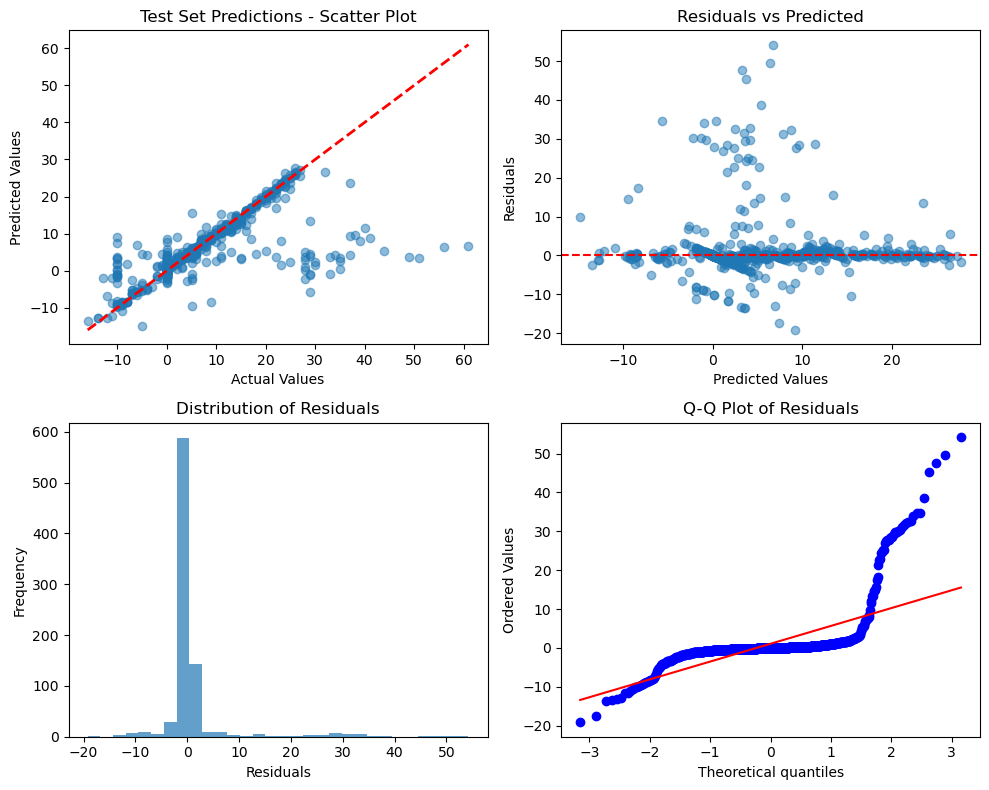

Final Test R²: 0.5233
Feature importance shape: (120, 2)


In [24]:
# Run the regressor
model, results = train_xgboost_regressor(X_train, X_holdout, y_train, y_holdout)

# Plot results
plot_predictions(y_holdout, results['y_pred_test'], "Test Set Predictions")

# Access results
print(f"Final Test R²: {results['test_r2']:.4f}")
print(f"Feature importance shape: {results['feature_importance'].shape}")